In [80]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt

**DICCIONARIOS CON LAS RUTAS**

In [30]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [31]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)

    if path == 'procssed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**CARACTERISTICAS DEL AUDIO**

In [32]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = 256

**FUNCIONES**

In [33]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [36]:
def trim(audio, top_db = 45):
    signal, sr, _ = load_audio(audio)
    output_file = os.path.join(os.path.dirname(audio), "trimed/" + os.path.basename(audio))
    signal, _ = librosa.effects.trim(signal, top_db = top_db, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)
    sf.write(output_file, signal, sr)

In [ ]:
def filter(audio):
    signal, sr, _ = load_audio(audio)
    

In [7]:
def calculate_smoothed_envelope(signal, sr, cutoff_frequency = 10.0):
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    amplitude_envelope = np.abs(analytic_signal)

    # Aplicar filtro pasa bajos para suavizar la envolvente
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    
    smoothed_envelope = filtfilt(b, a, amplitude_envelope)

    return amplitude_envelope, smoothed_envelope

In [6]:
def get_sphere(vectors):
    center = np.mean(vectors, axis = 0)
    center = center.reshape(1, -1)
    radius = cdist(center, vectors).max()     # Pairwise distance
    return radius, center

In [5]:
def get_centers(features):
    centers = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        _, center = get_sphere(group)
        centers[fruit] = center
    return centers

In [4]:
def get_radiuses(features):
    radiuses = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        radius, _ = get_sphere(group)
        radiuses[fruit] = radius
    return radiuses

In [3]:
def get_overlaps(fruit_features):
    centers = get_centers(fruit_features)
    radiuses = get_radiuses(fruit_features)
    overlaps = dict.fromkeys(fruit_features.keys())
    
    # A dictionary of dictionarys. Keys, the fruit types
    for key in overlaps:
        # Each dictionary in the dictionary
        overlaps[key] = dict.fromkeys(fruit_types)
    
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            distancesAB = cdist(centers[fruit_types[i]], fruit_features[fruit_types[j]])
            distancesBA = cdist(centers[fruit_types[j]], fruit_features[fruit_types[i]])

            mask_distancesAB = distancesAB < radiuses[fruit_types[i]]
            mask_distancesBA = distancesBA < radiuses[fruit_types[j]]

            numberBinA = np.count_nonzero(mask_distancesAB)
            numberAinB = np.count_nonzero(mask_distancesBA)

            overlaps[fruit_types[i]][fruit_types[j]] = numberBinA
            overlaps[fruit_types[j]][fruit_types[i]] = numberAinB
    return overlaps # Each element is the number of vectors of one group in the sphere of another

In [1]:
def get_components(centers, nc):
    pacum = np.zeros((1, centers[fruit_types[0]].shape[1]))
    pair_components = dict()
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            dif = centers[fruit_types[i]] - centers[fruit_types[j]]
            dist = cdist(centers[fruit_types[i]], centers[fruit_types[j]])
            difp = (dif**2)*100/(dist**2)
            pair_components[f"{fruit_types[i]}-{fruit_types[j]}"]= np.argsort(difp[0])[-nc:]
            pacum += difp
    index_max = np.argsort(pacum[0])[-nc:]
    #return np.sort(index_max)
    return index_max, pair_components

**PRINCIPAL**

**KNN**

In [2]:
def knn(training, test, k_n):
    X = np.concatenate([v for v in training.values()], axis=0)
    y = np.concatenate([[k] * v.shape[0] for k, v in training.items()])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors = k_n)

    # Entrenar el clasificador
    knn_classifier.fit(X, y)

    # Predecir las etiquetas para los datos de prueba
    predicted_fruit = knn_classifier.predict(test)

    print(f'La fruta predicha para el nuevo audio es: {predicted_fruit[0]}')

**PLOTEO**

In [ ]:
#2d
fig = plt.figure()

colors = dict(zip(fruit_types,['green','yellow','red','orange']))
center_colors  = dict(zip(fruit_types,['blue','brown','black','cyan']))

for fruit, points in features.items():
    plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

plt.xlabel('Eje X')
plt.ylabel('Eje Y')

plt.show()

In [ ]:
#3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for fruit, points in features.items():
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
    #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

# configure labels
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
plt.show()

In [49]:
#signal
def plot_signal(audio):
    signal, sr, duration = load_audio(audio)
    time_vector = np.linspace(0, duration, len(signal))

    plt.figure(figsize=(15, 5))
    
    #plot
    #librosa.display.waveshow(signal)
    
    plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio {os.path.basename(audio)} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

**Lo primero vamos a ver como funciona la función de recorte y los filtros**

In [56]:
#trim de los audios
for type, group in audios.items():
    for audio in group:
        trim(audio, 20)

C:\Users\Juan\AppData\Local\Temp\ipykernel_9544\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


C:\Users\Juan\AppData\Local\Temp\ipykernel_9544\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


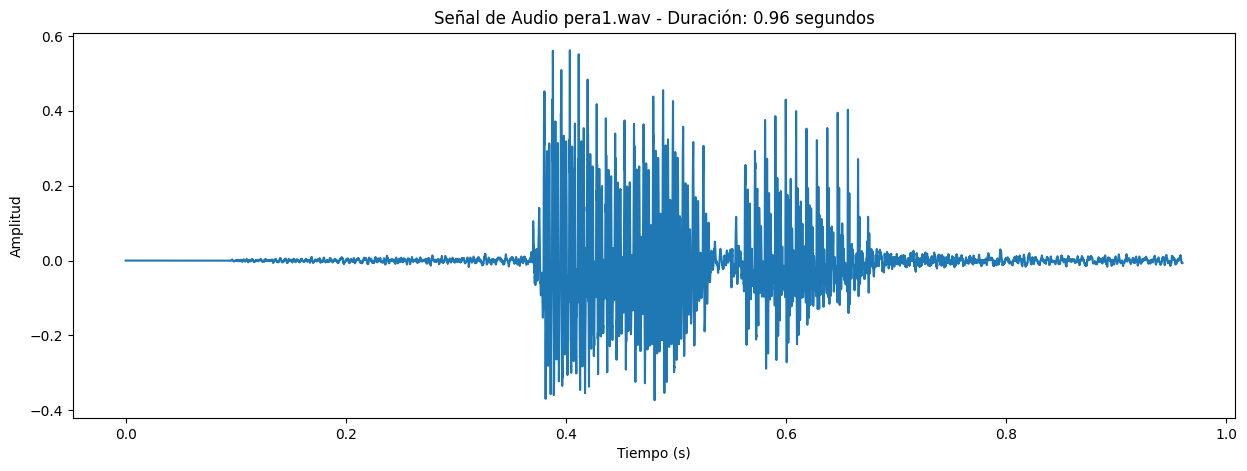

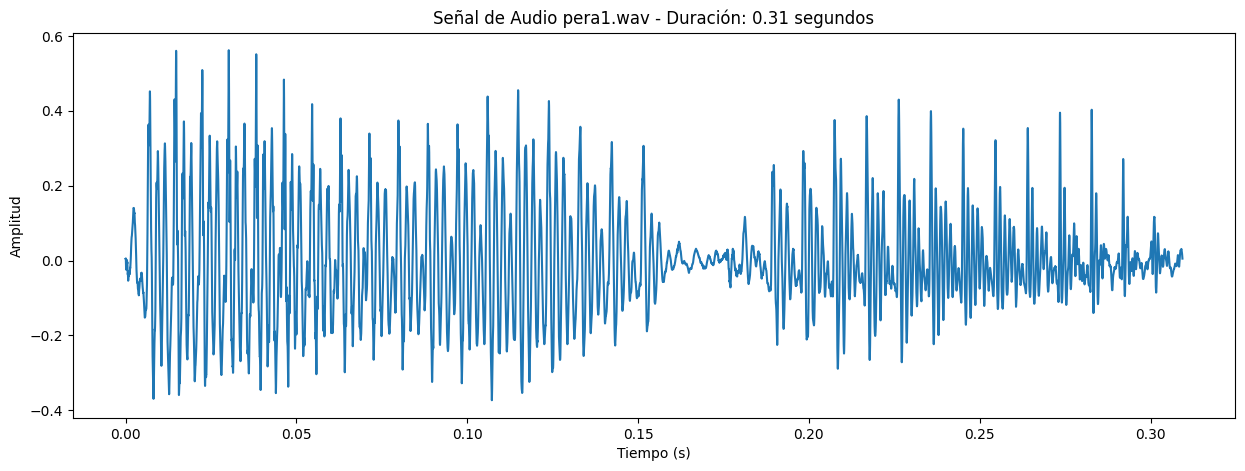

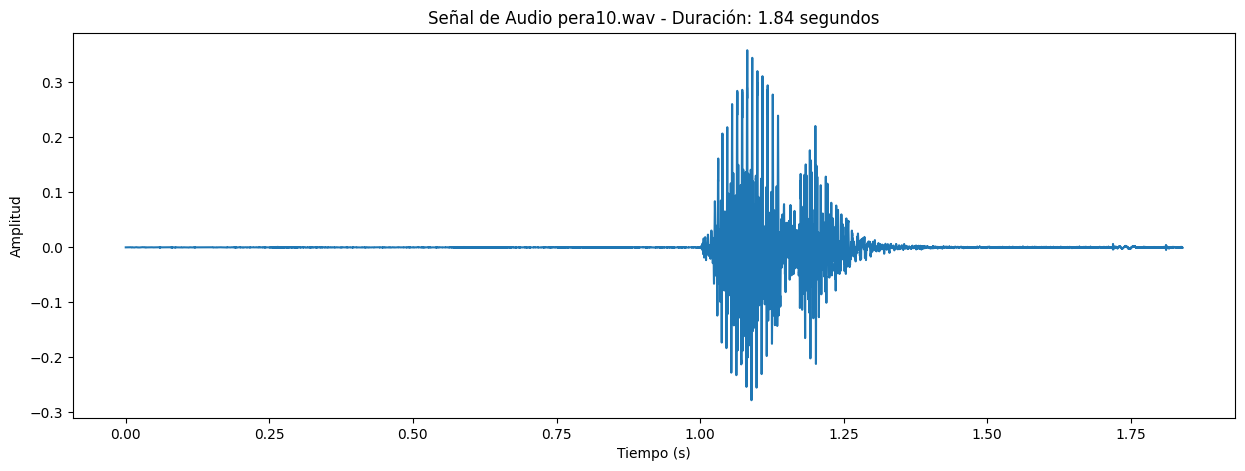

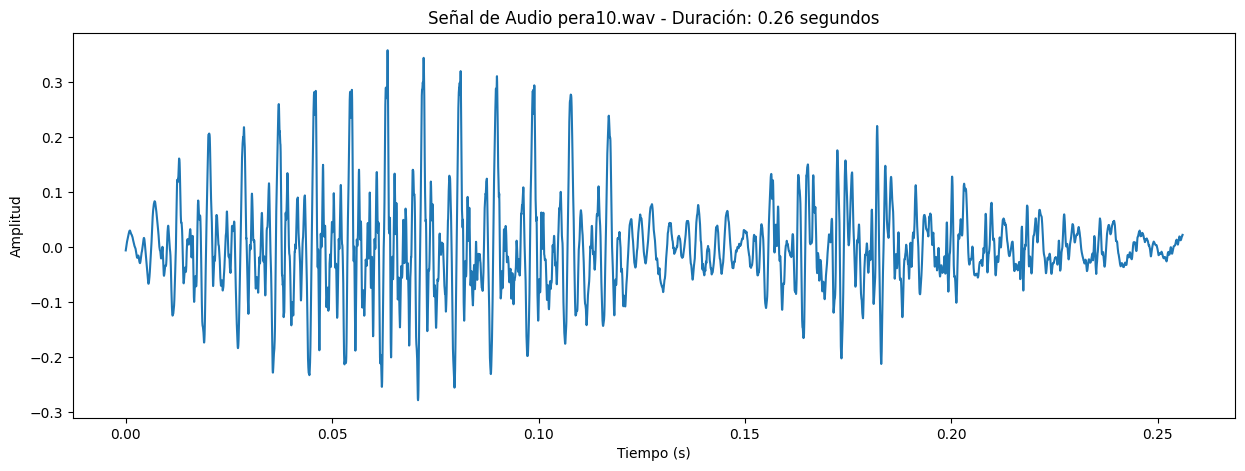

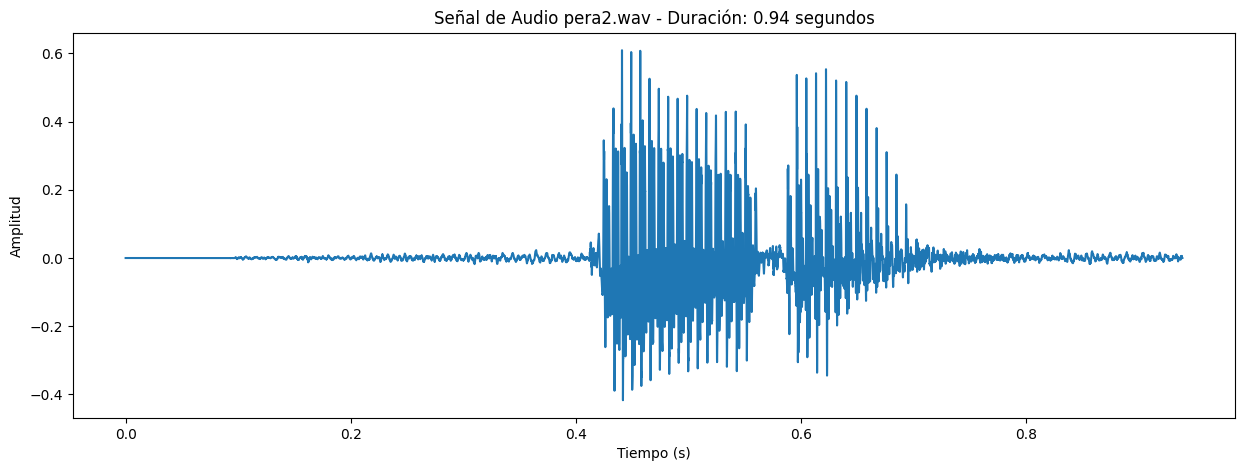

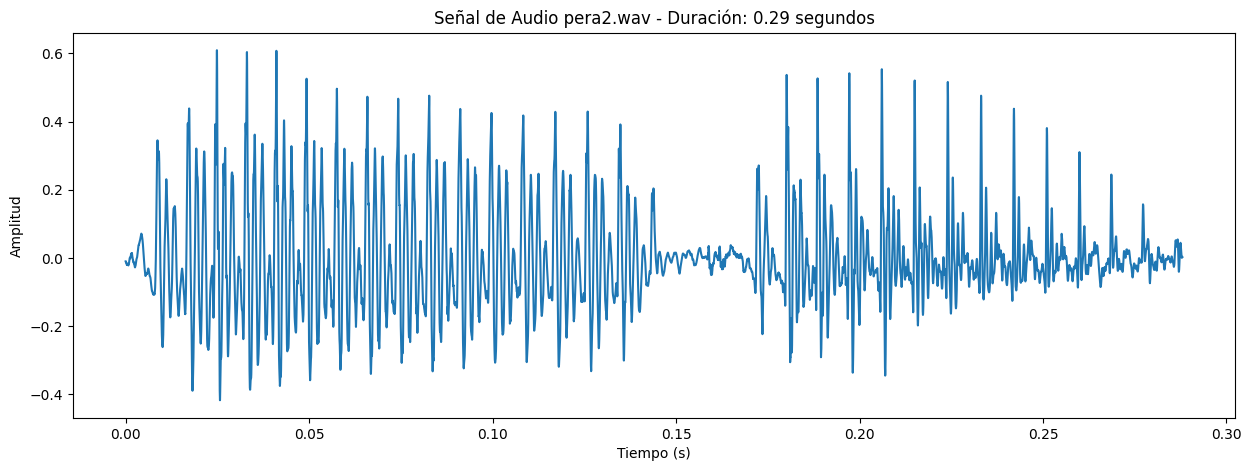

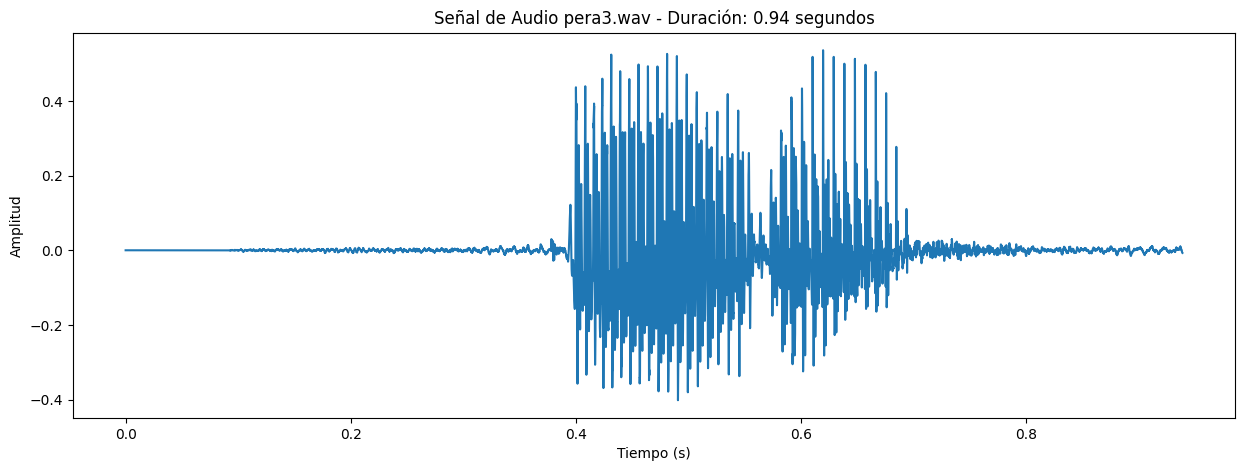

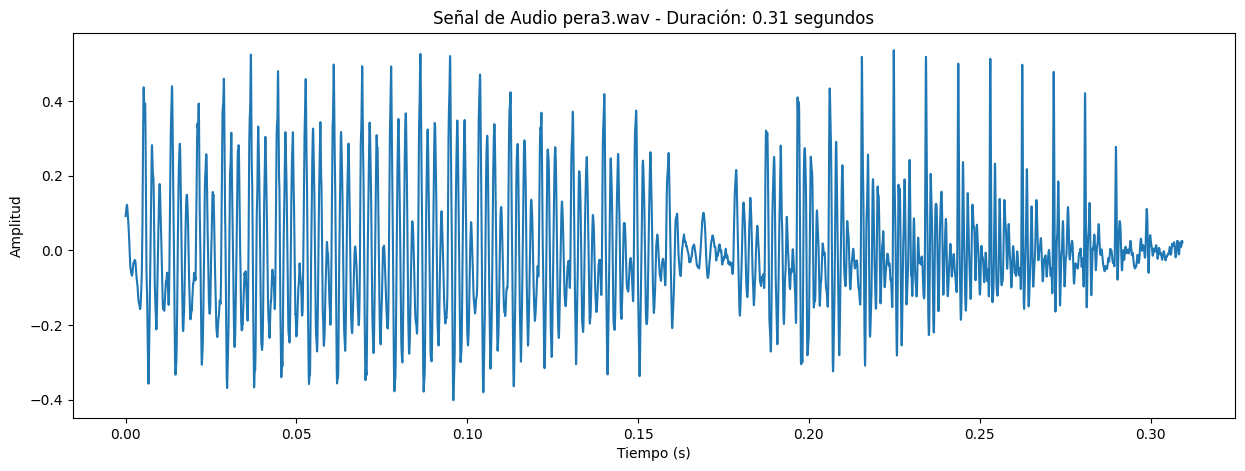

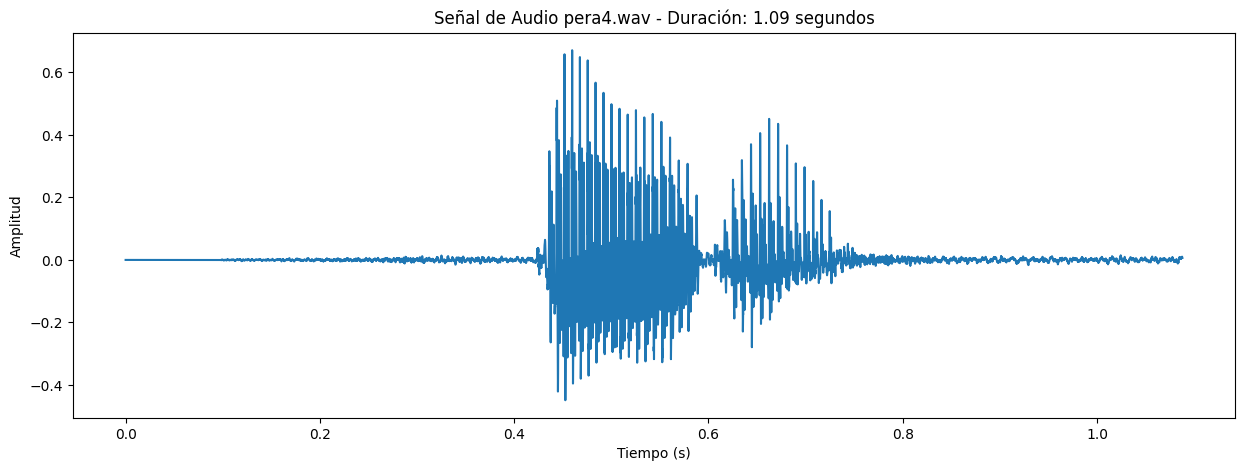

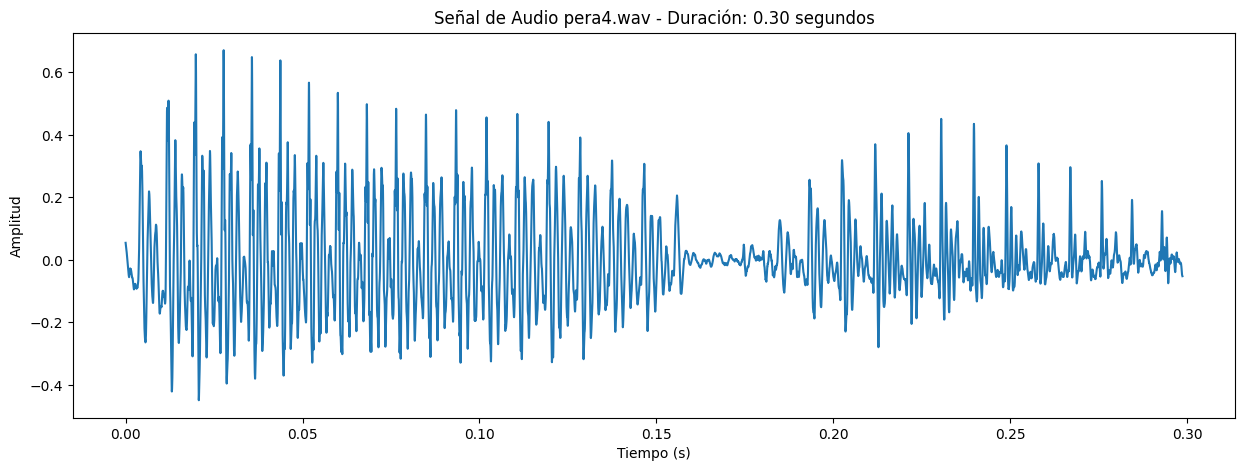

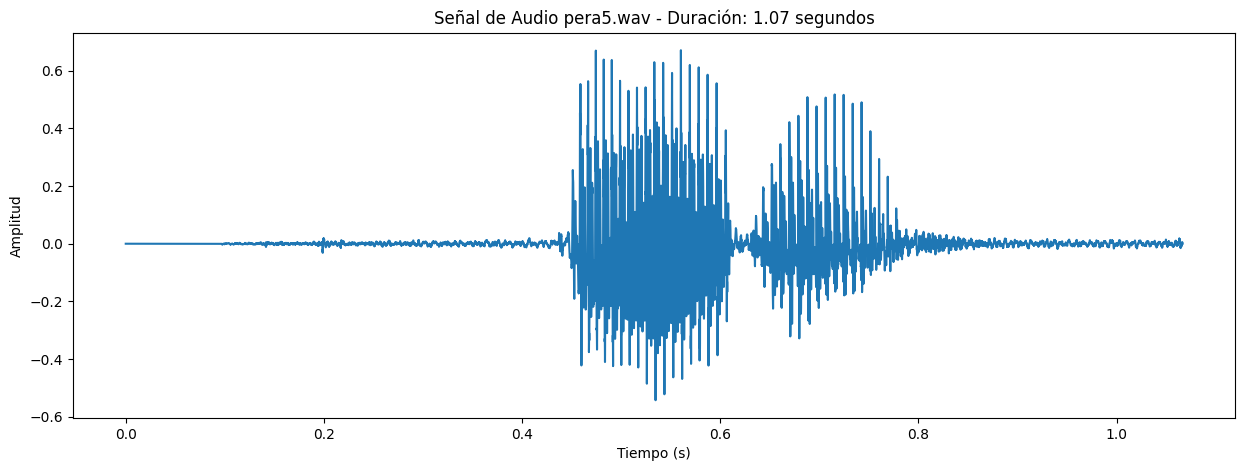

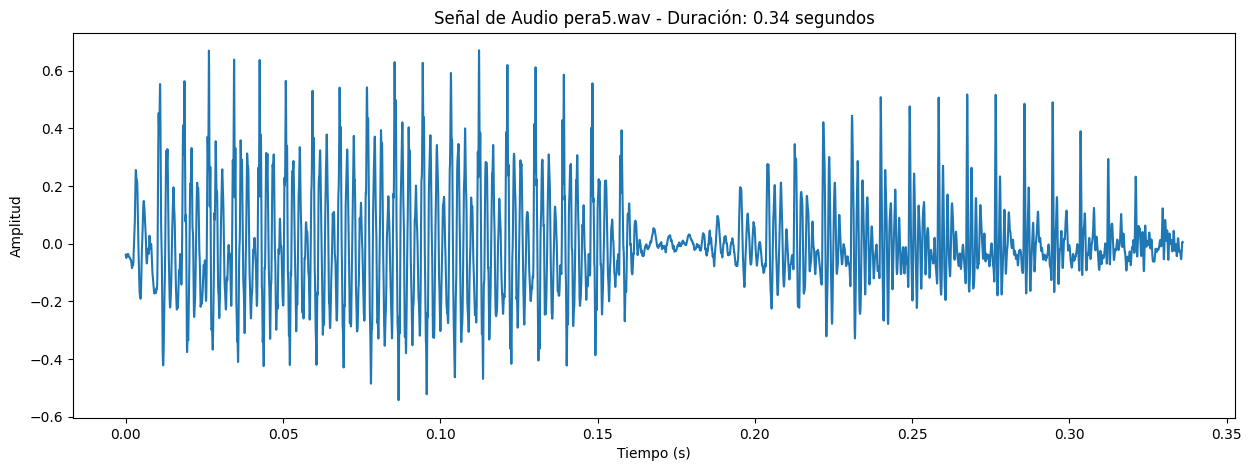

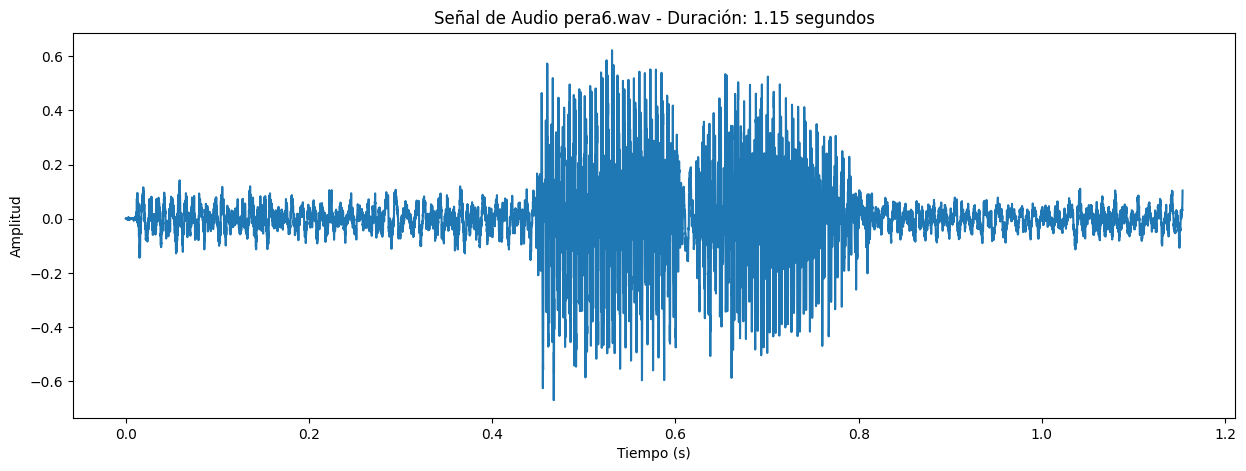

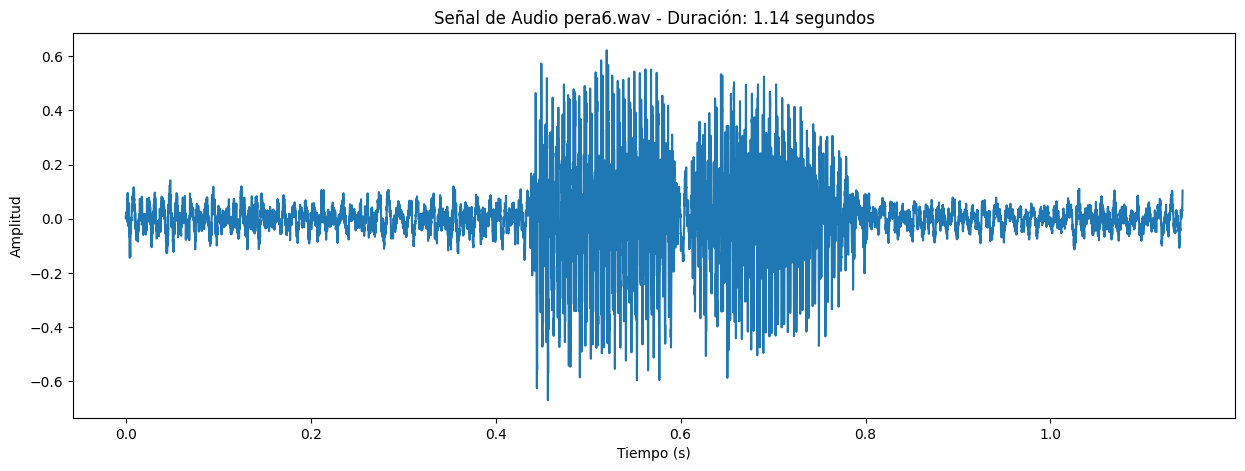

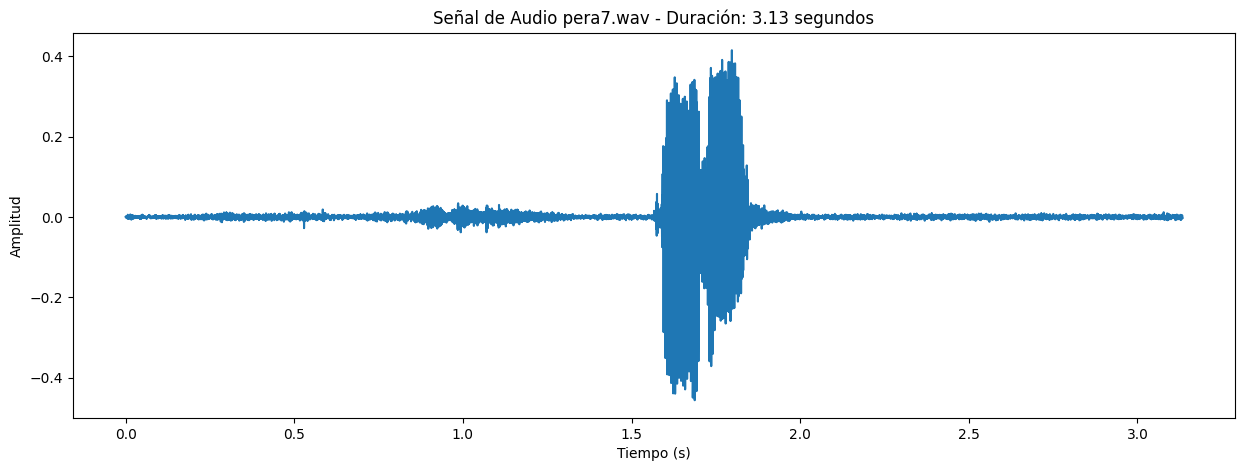

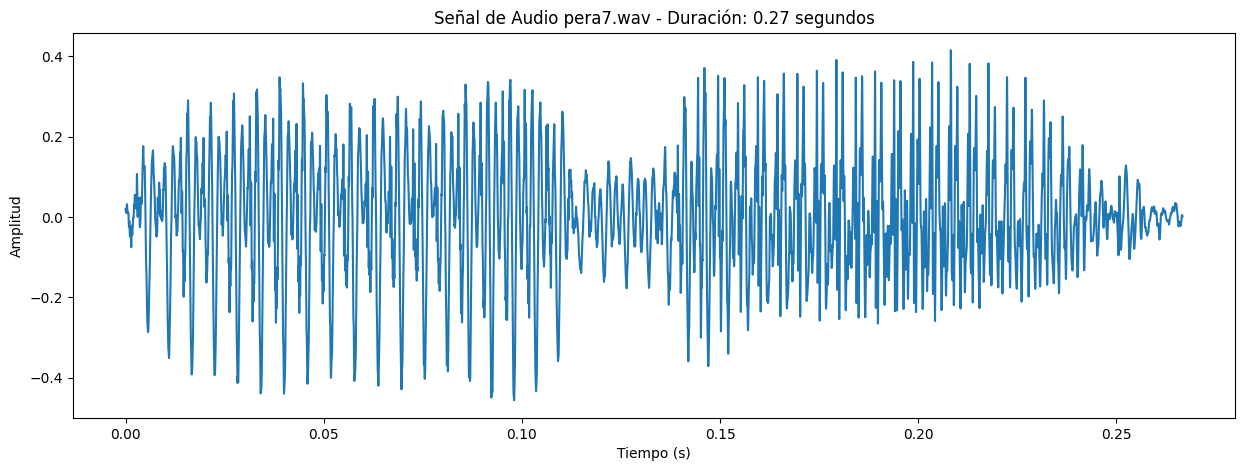

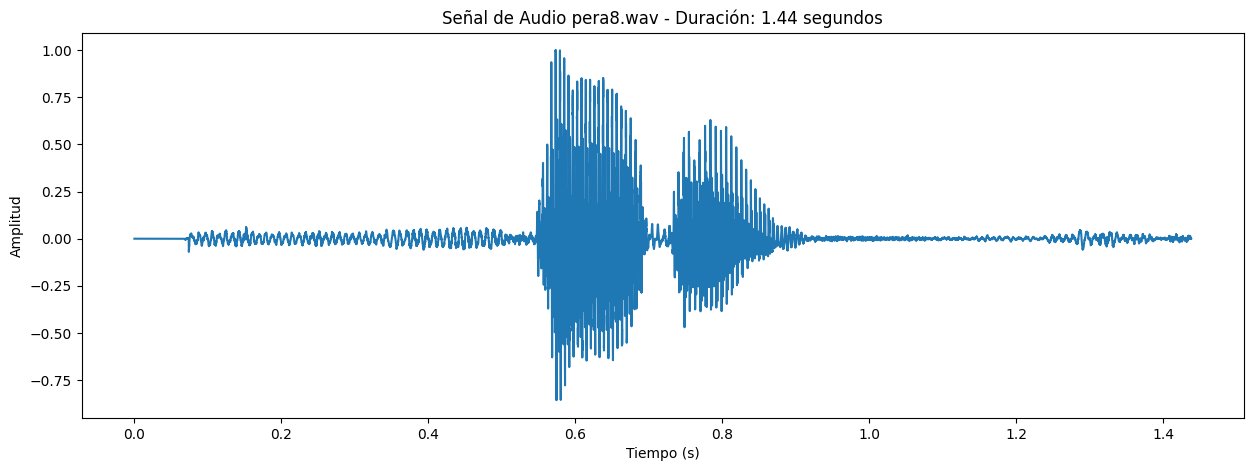

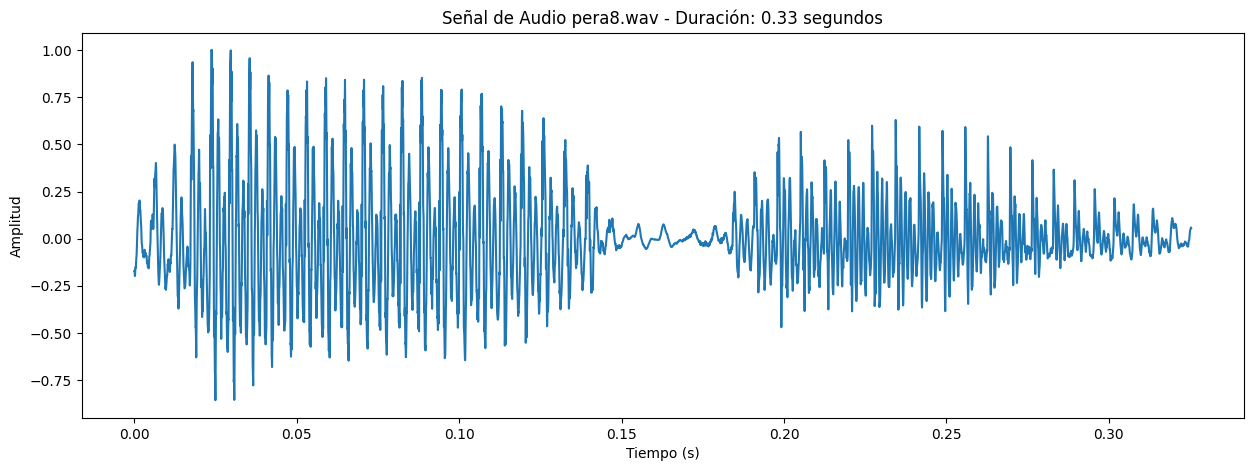

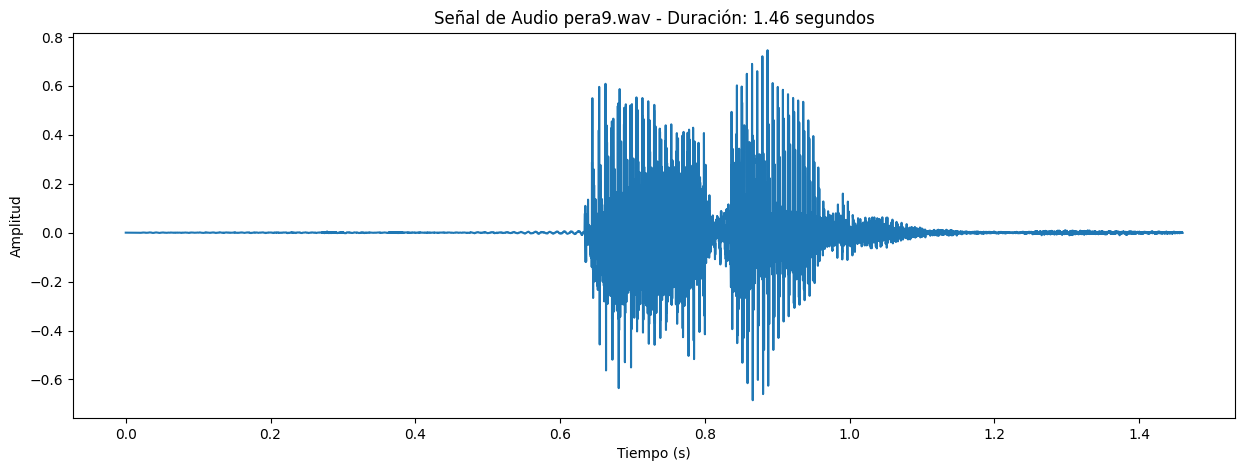

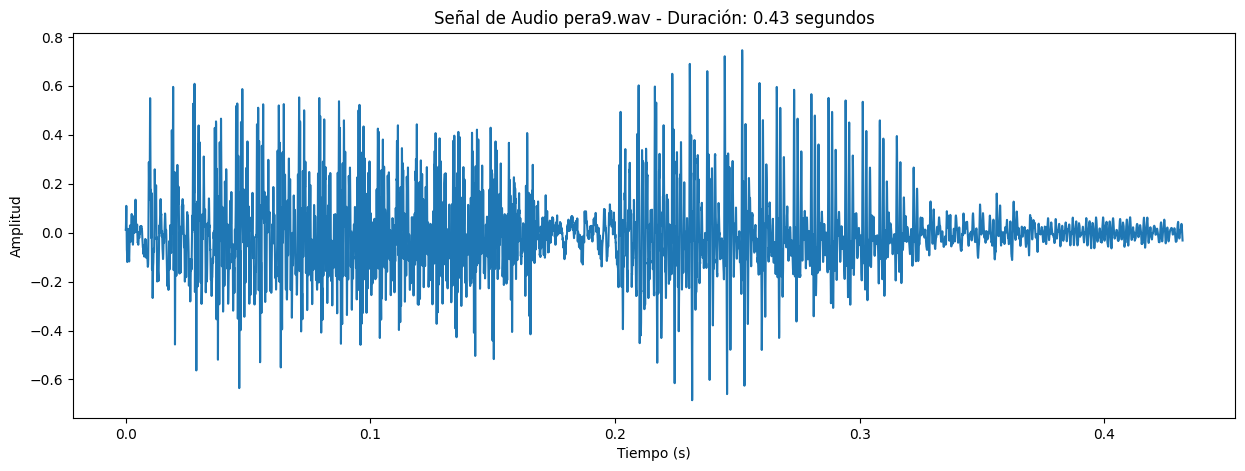

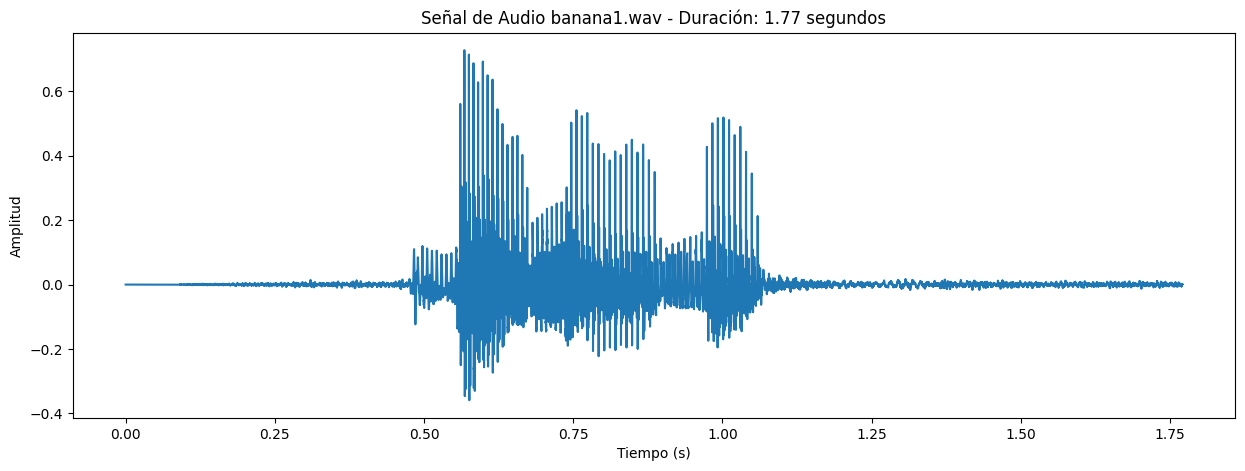

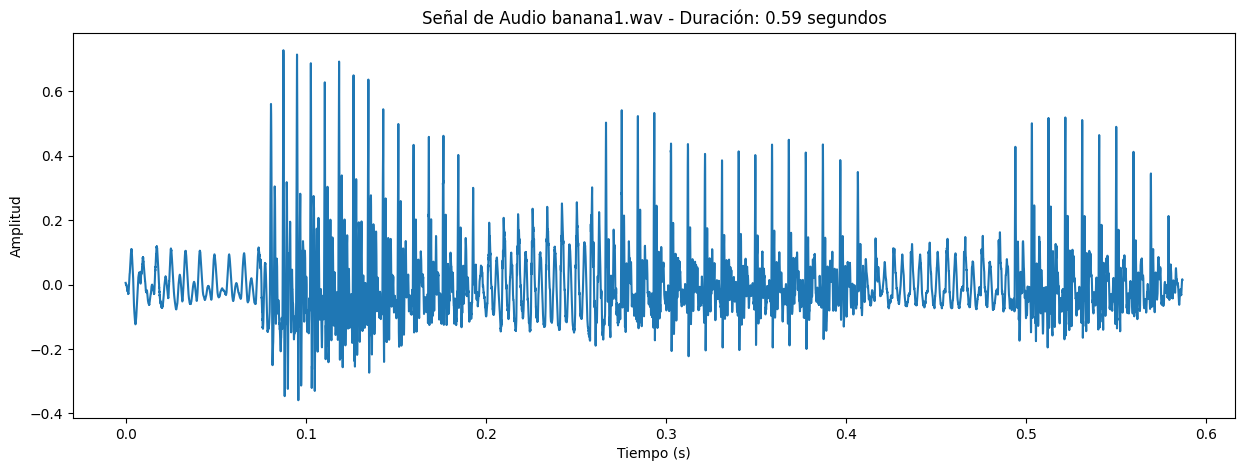

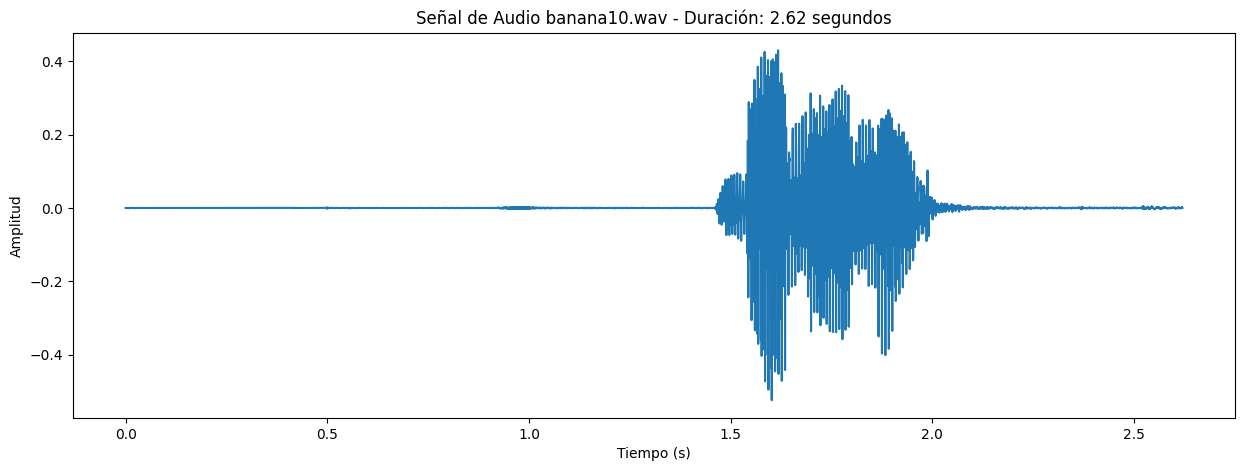

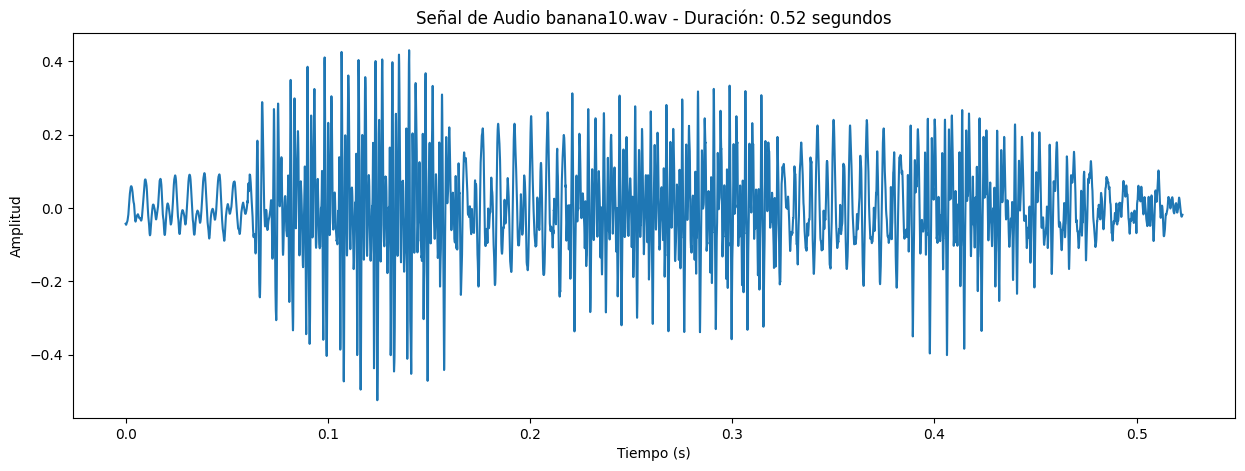

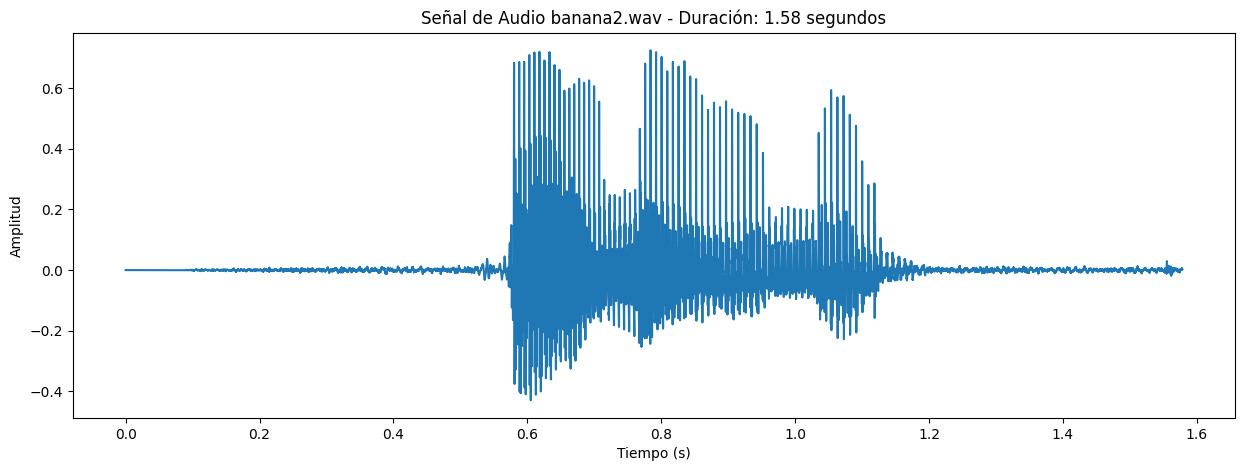

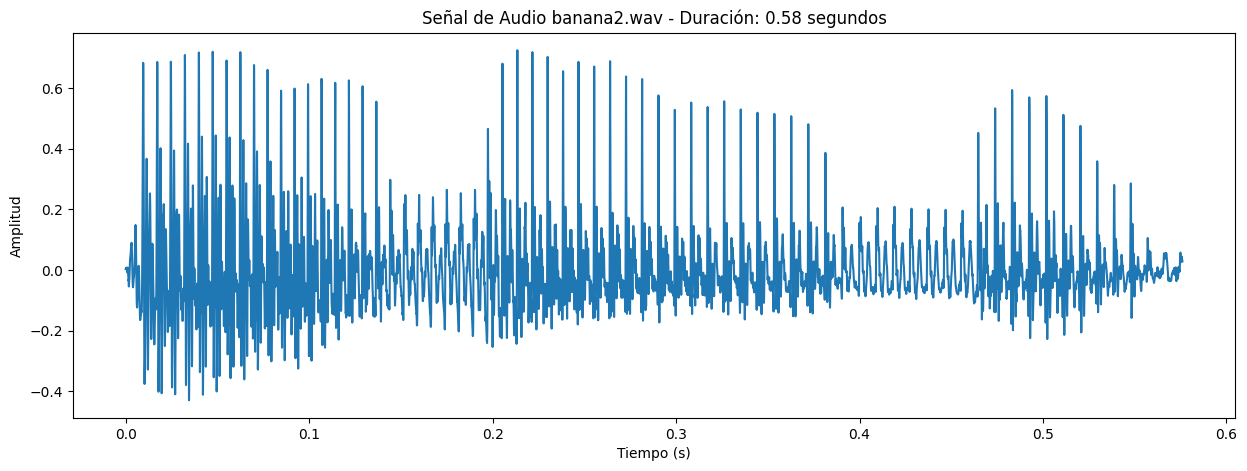

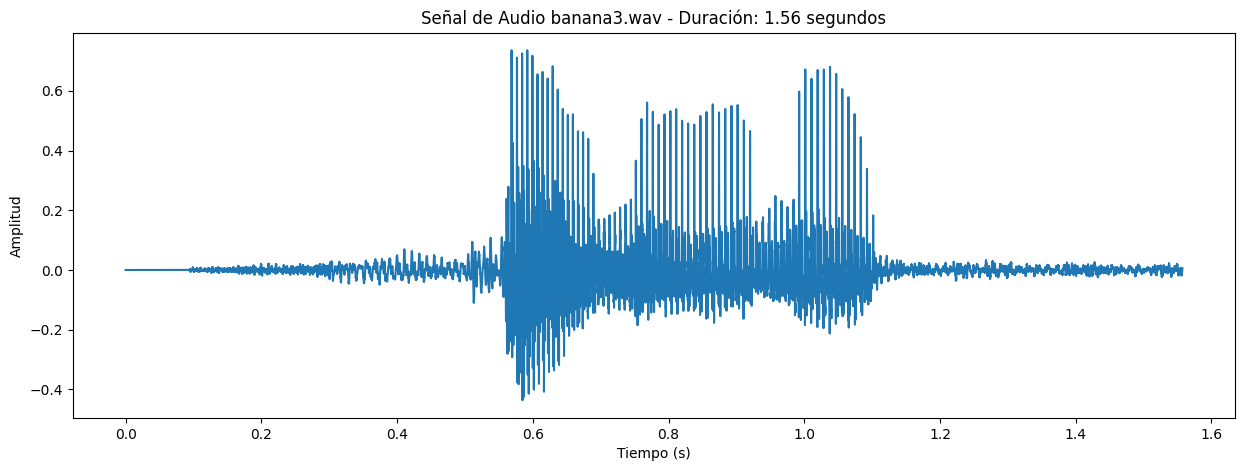

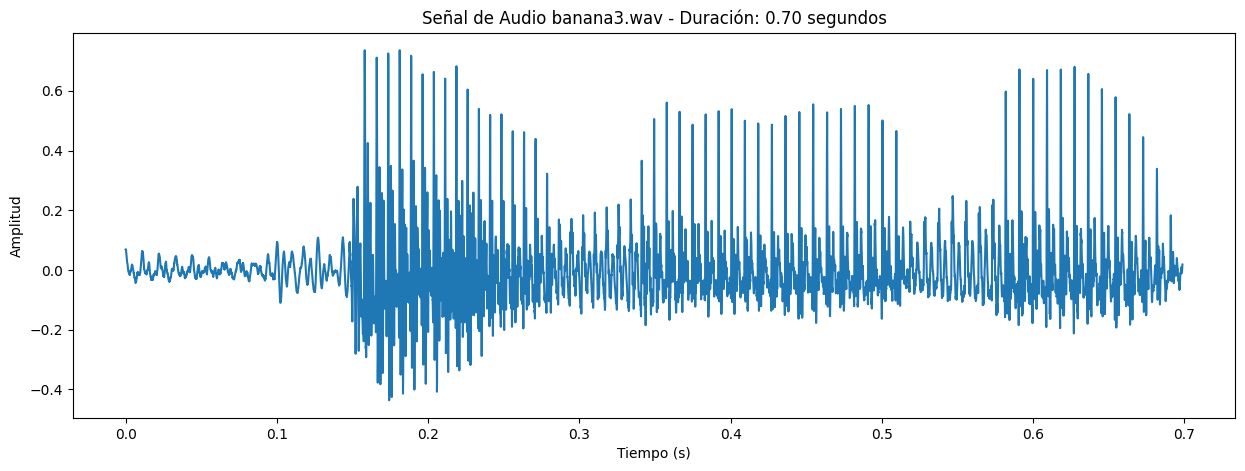

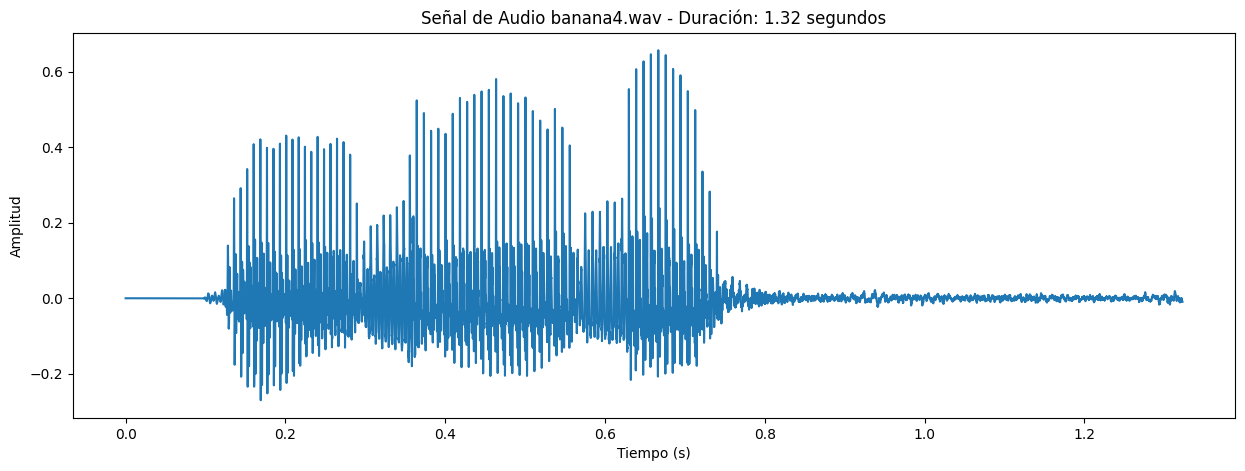

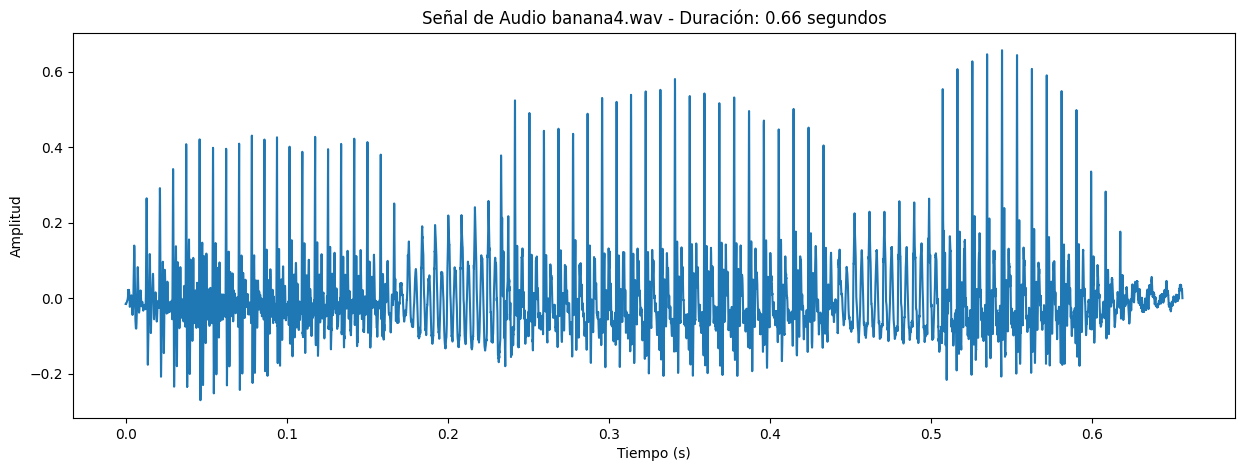

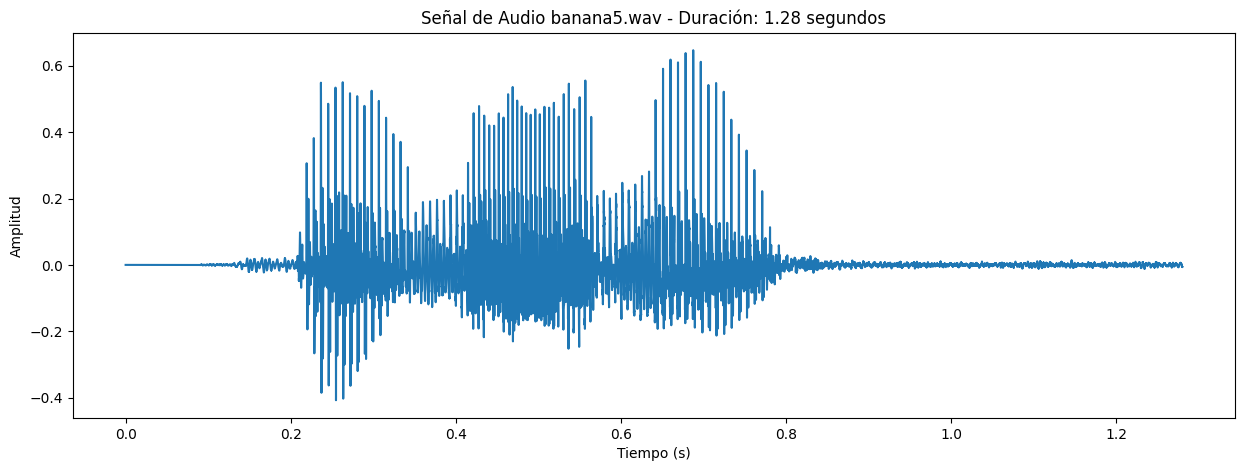

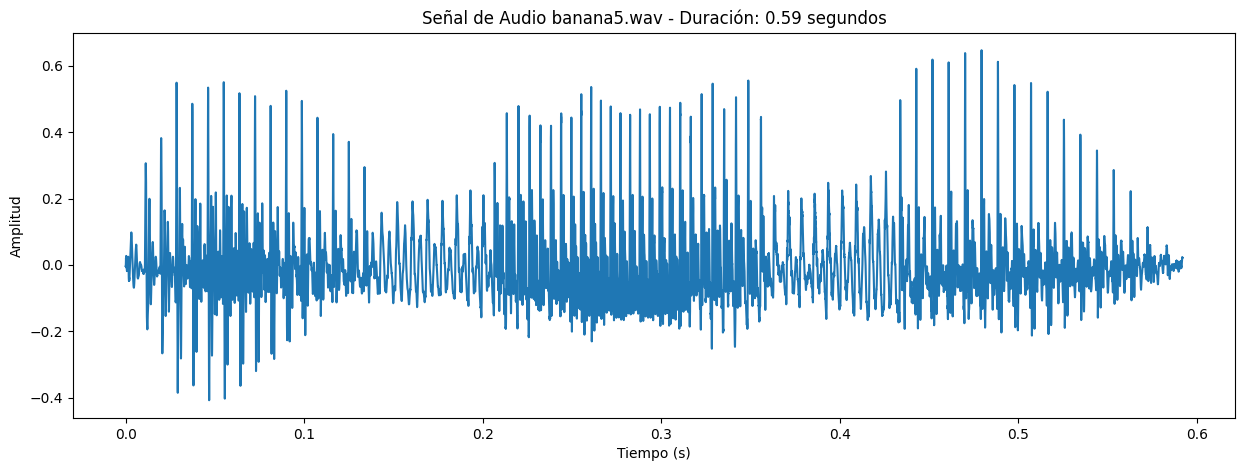

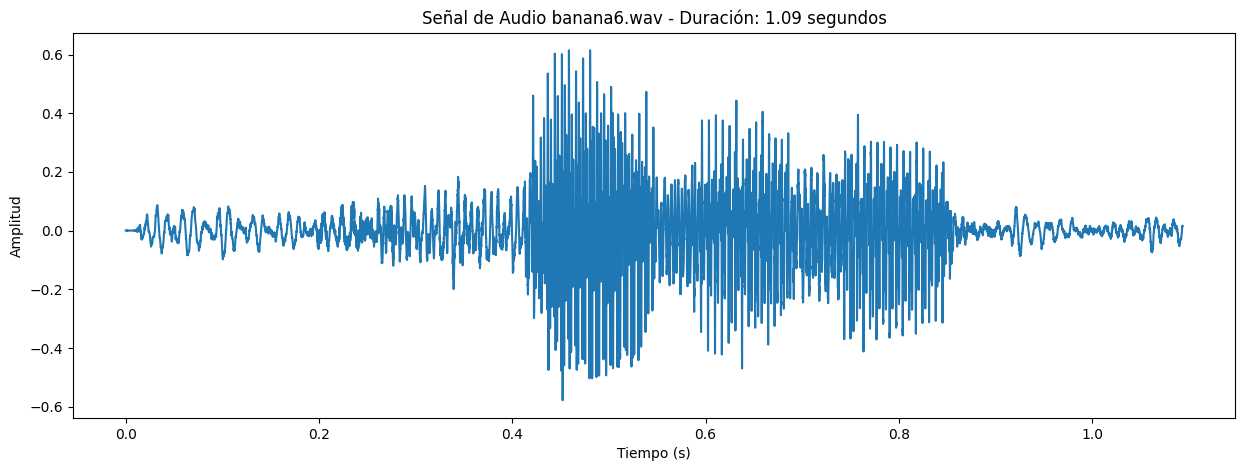

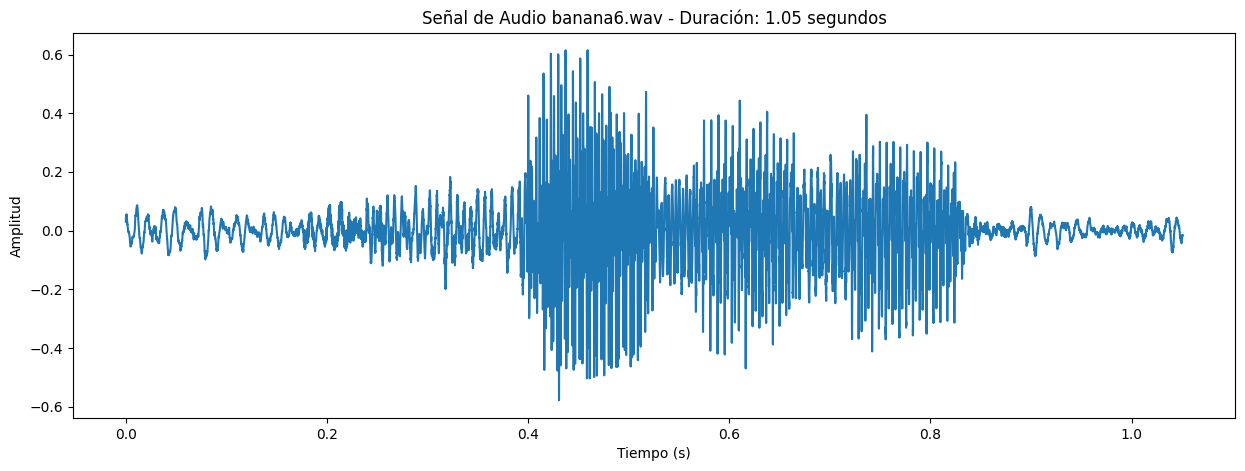

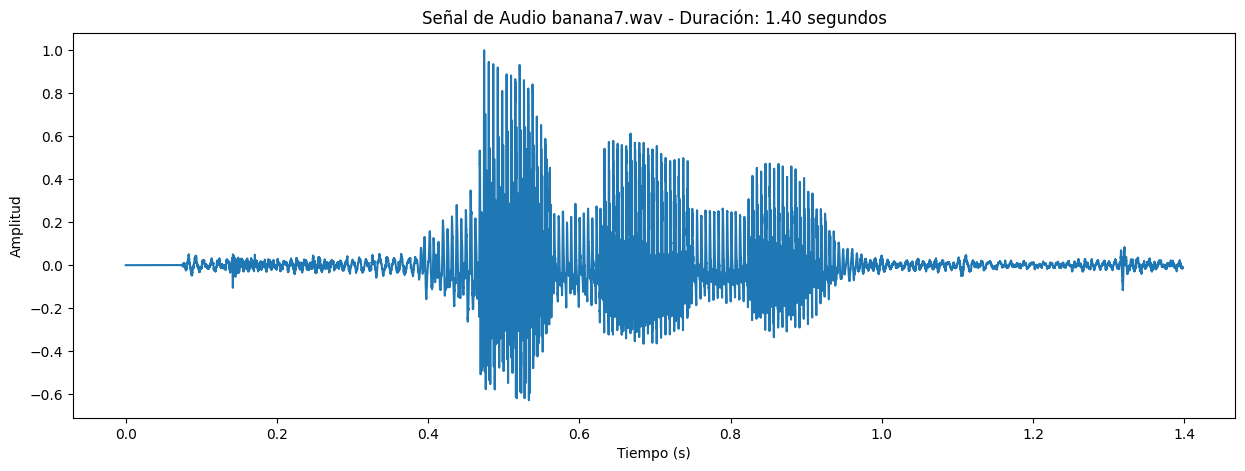

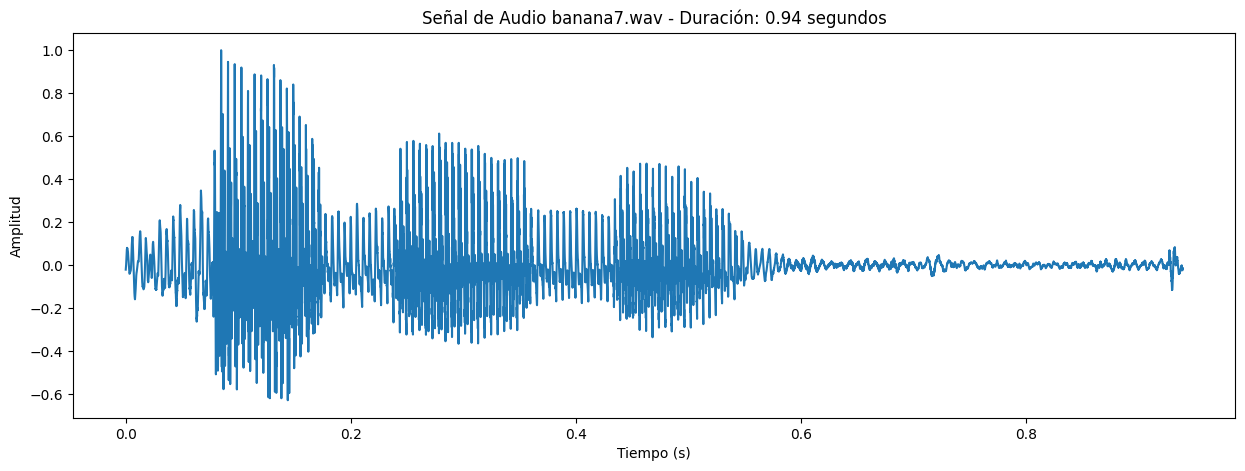

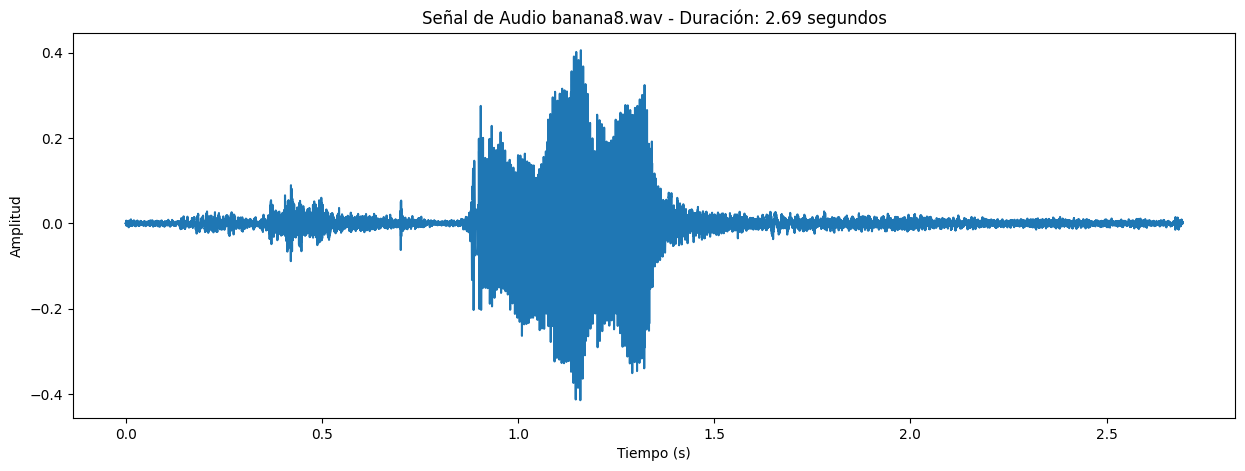

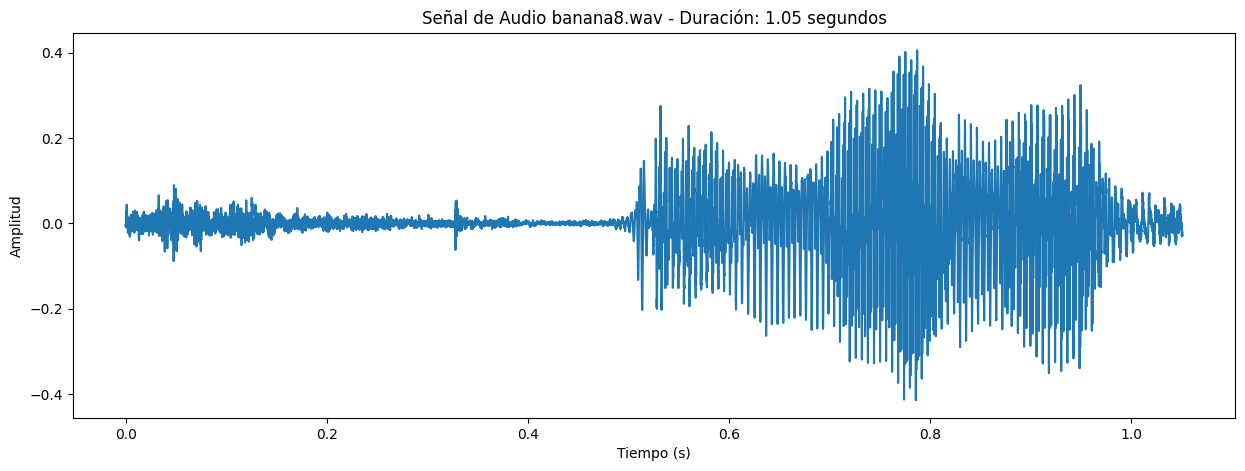

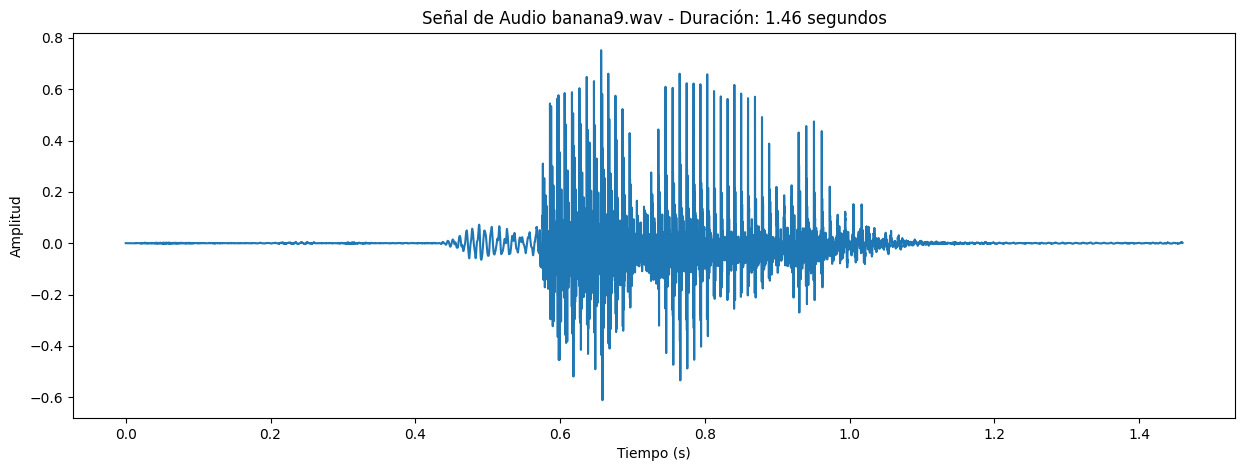

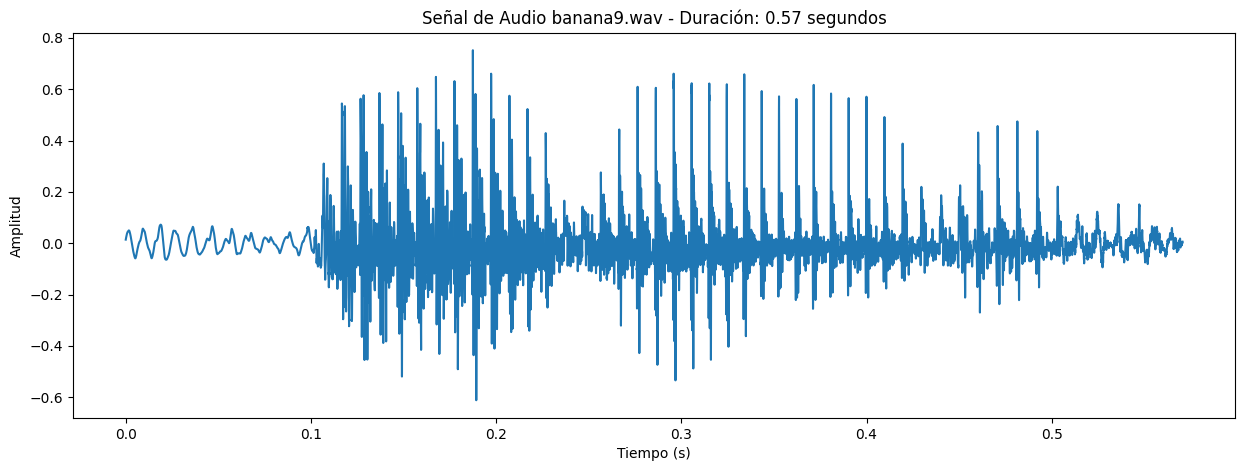

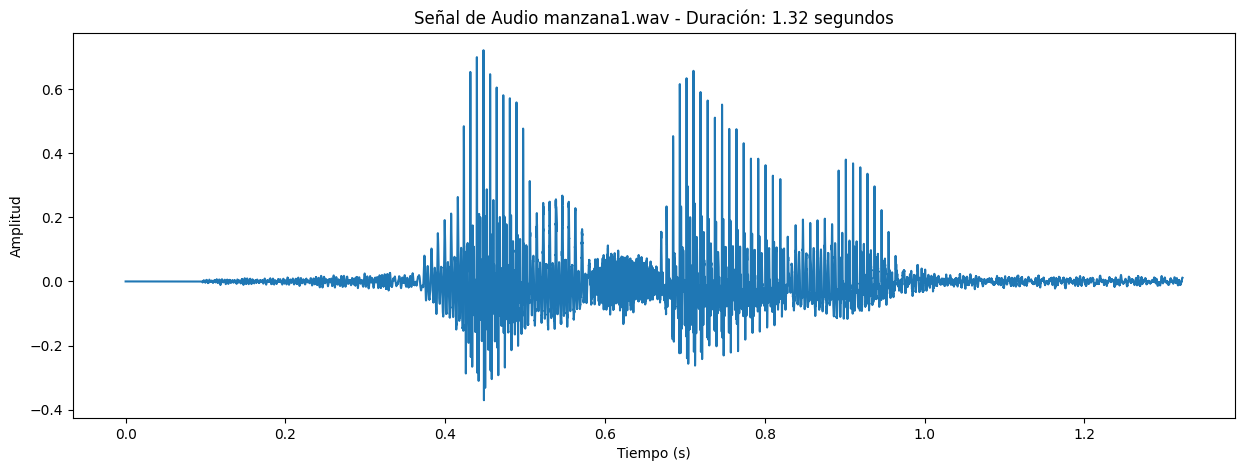

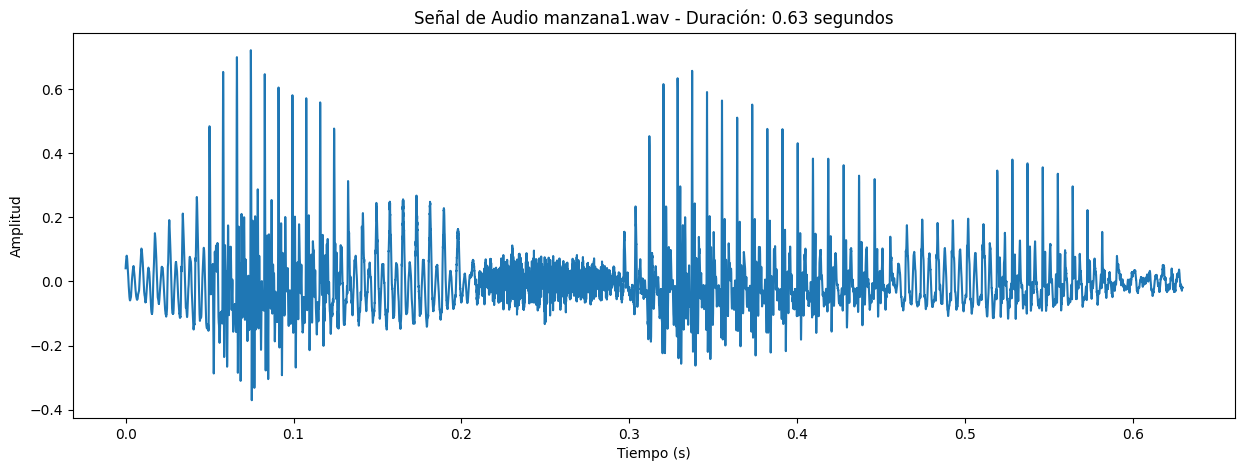

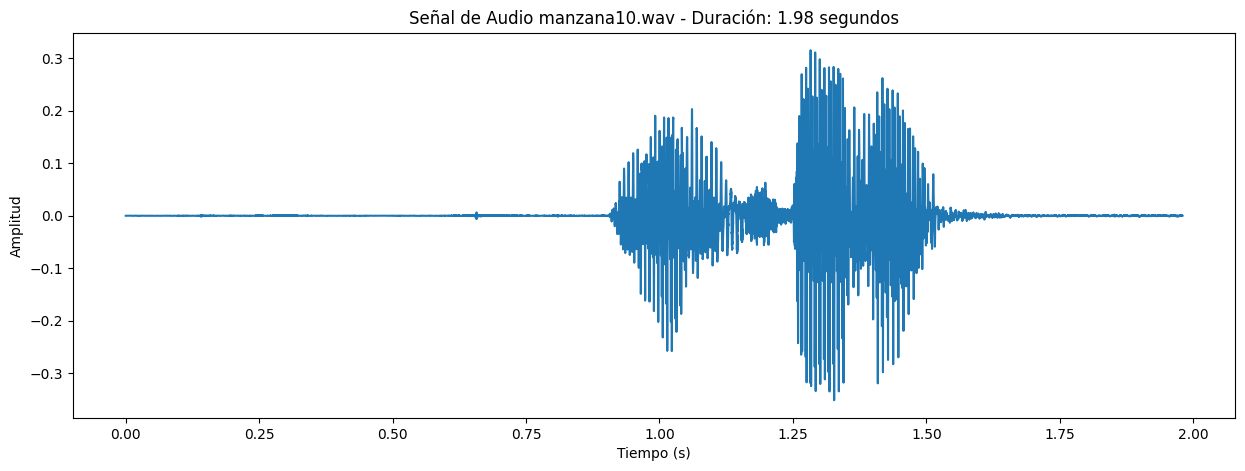

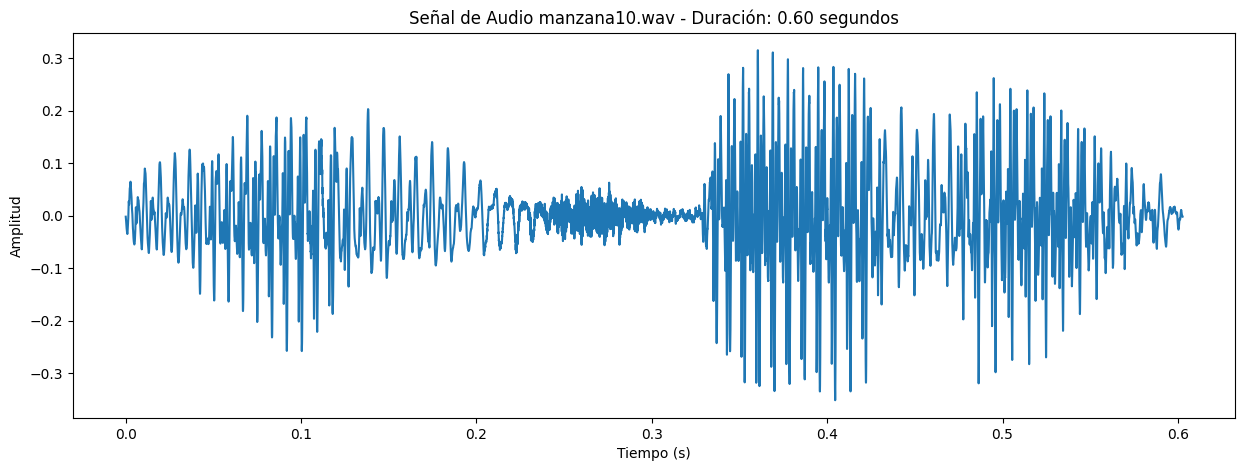

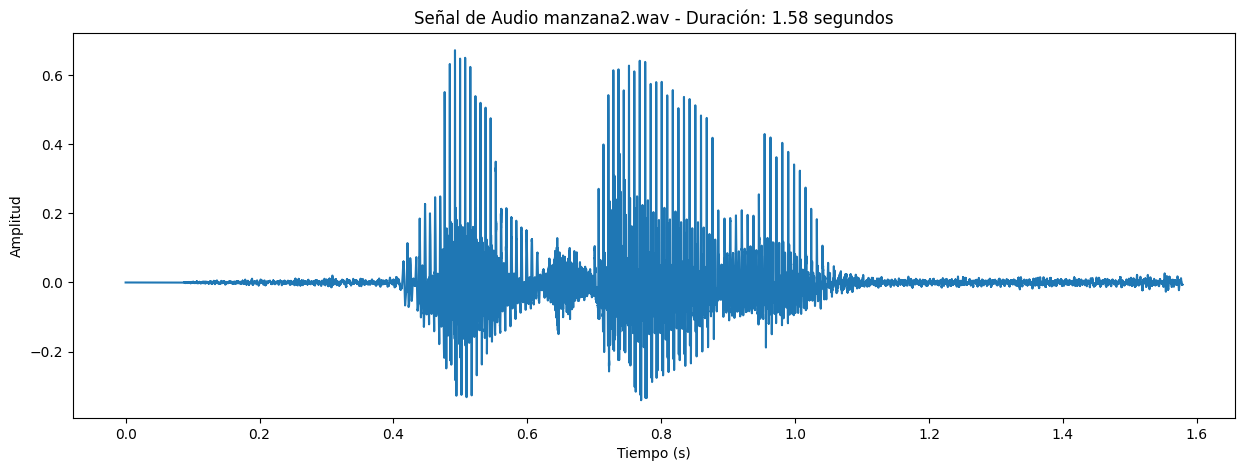

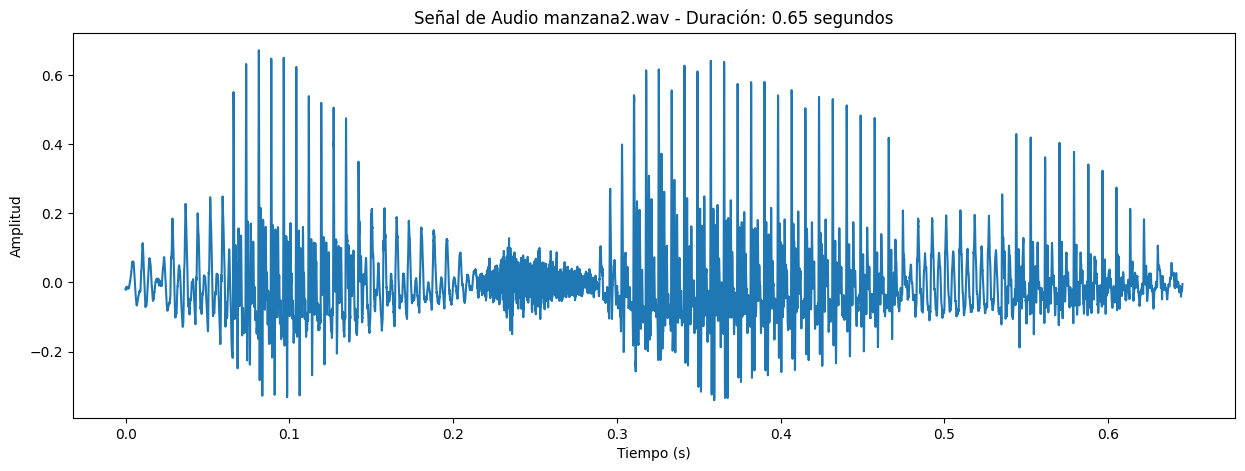

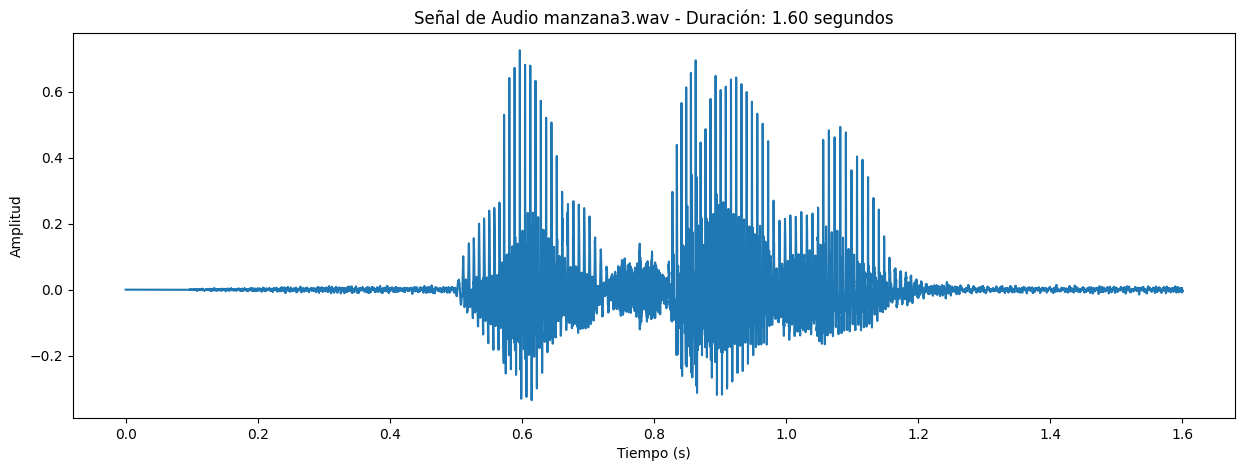

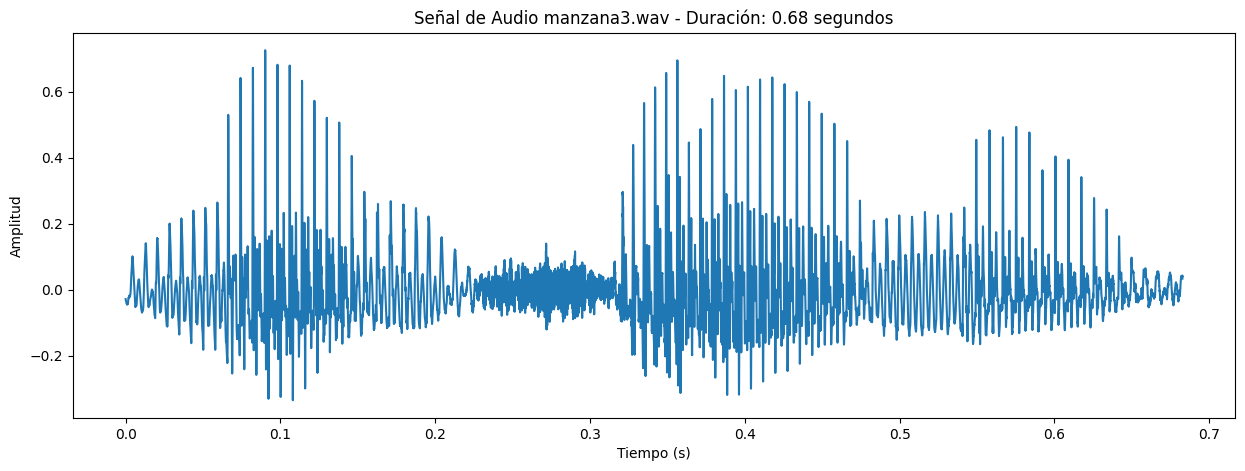

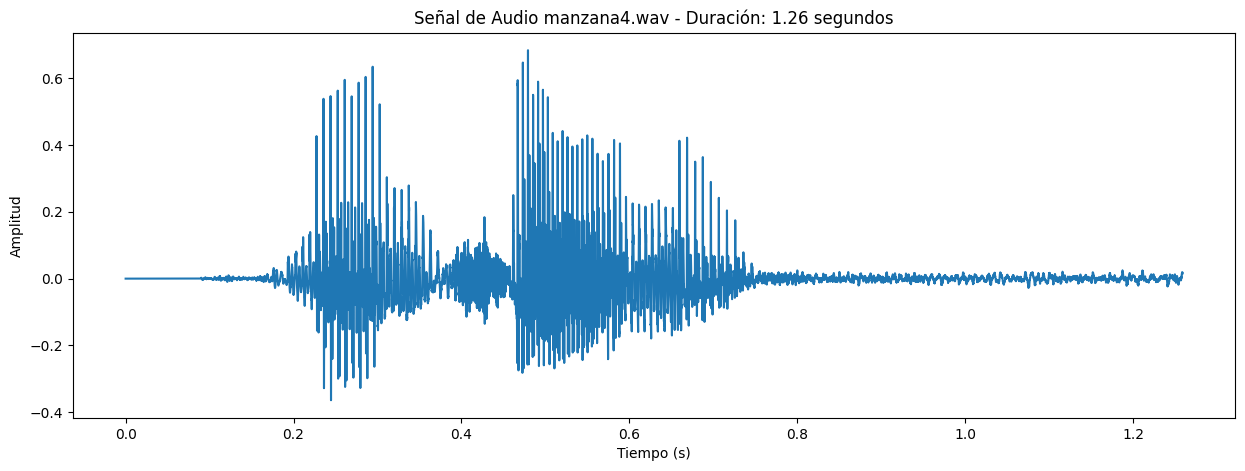

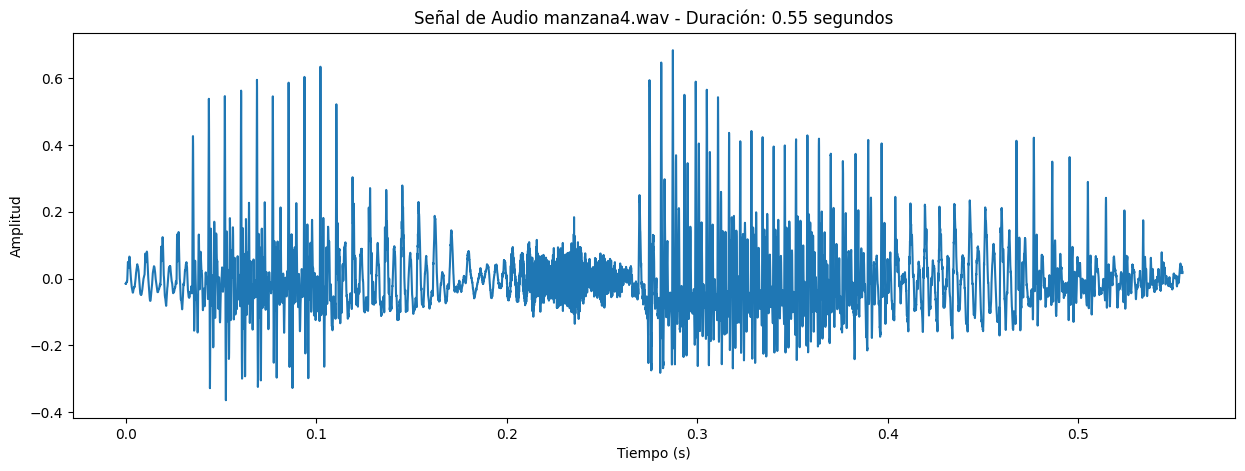

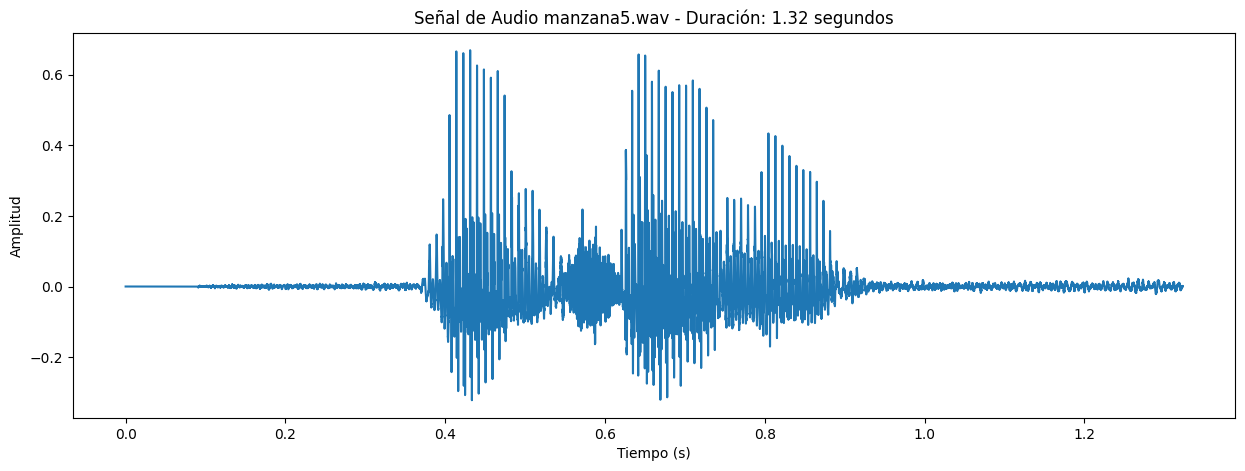

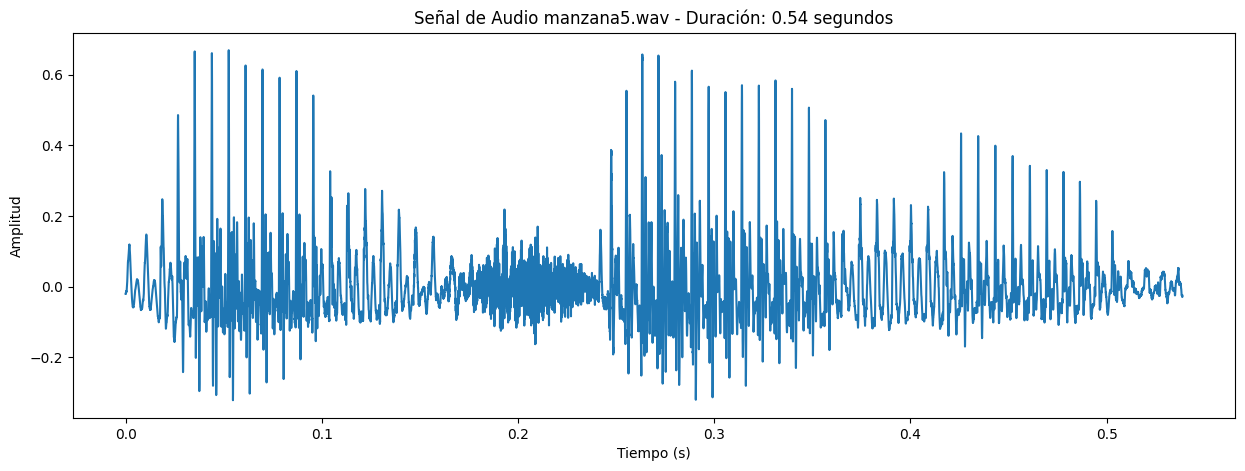

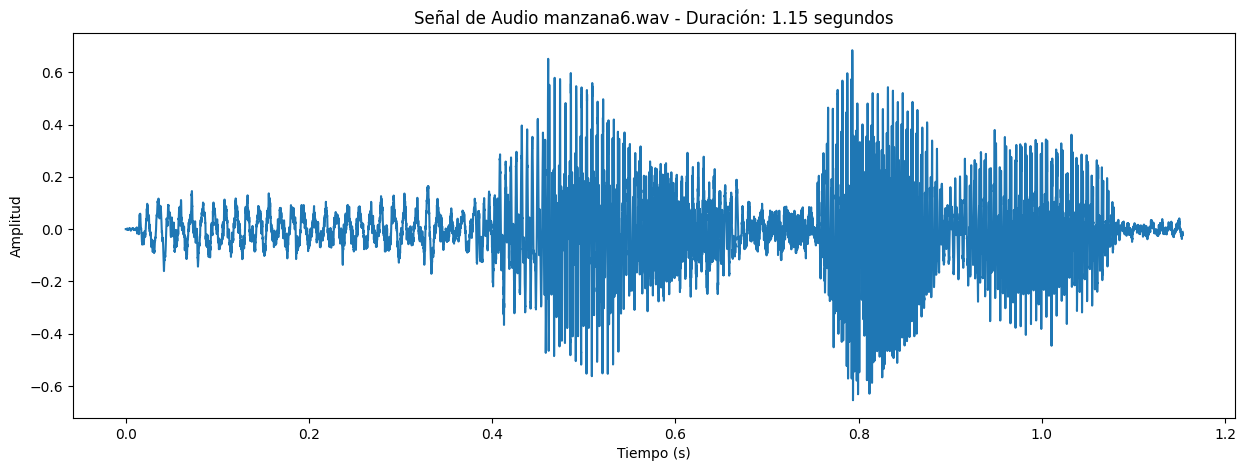

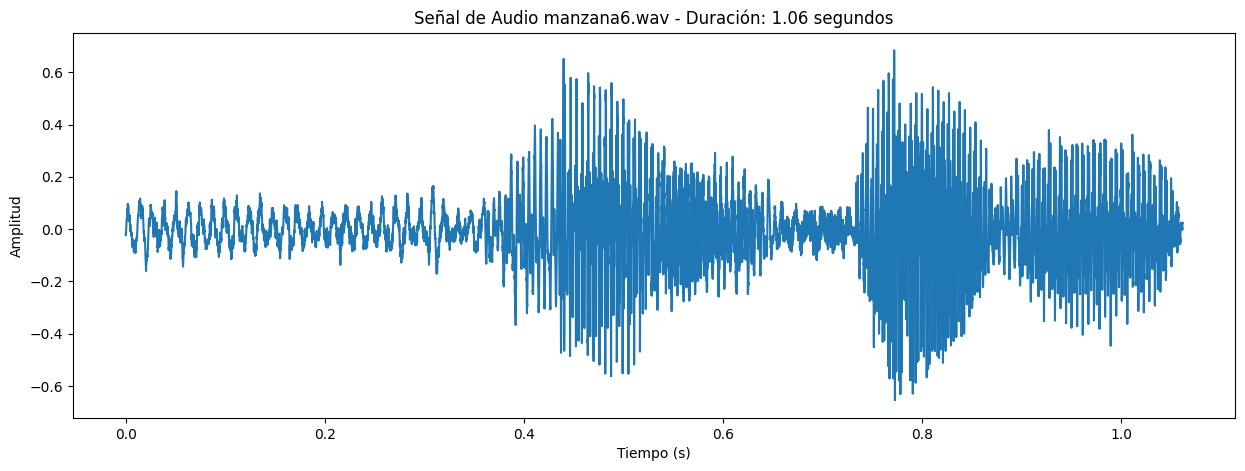

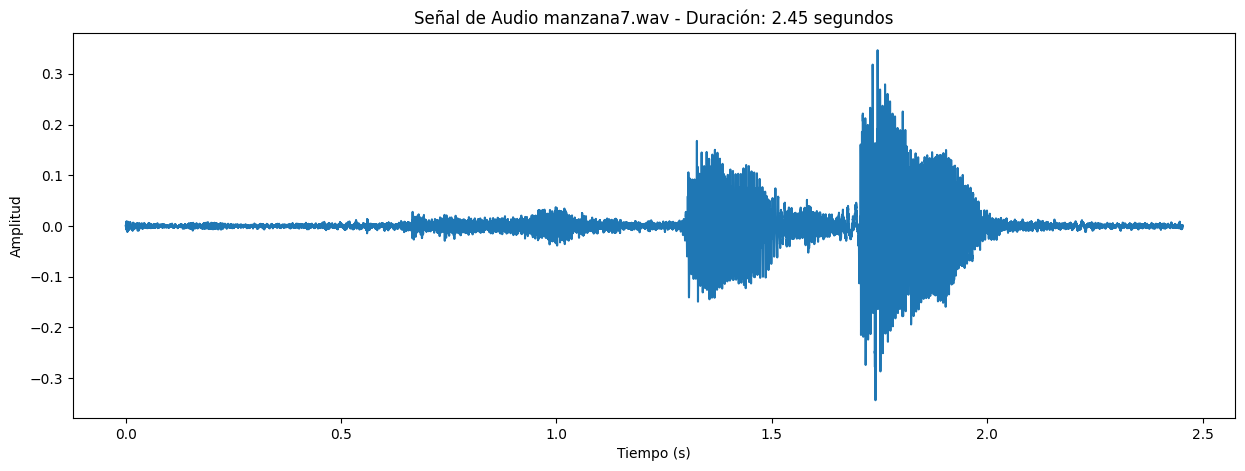

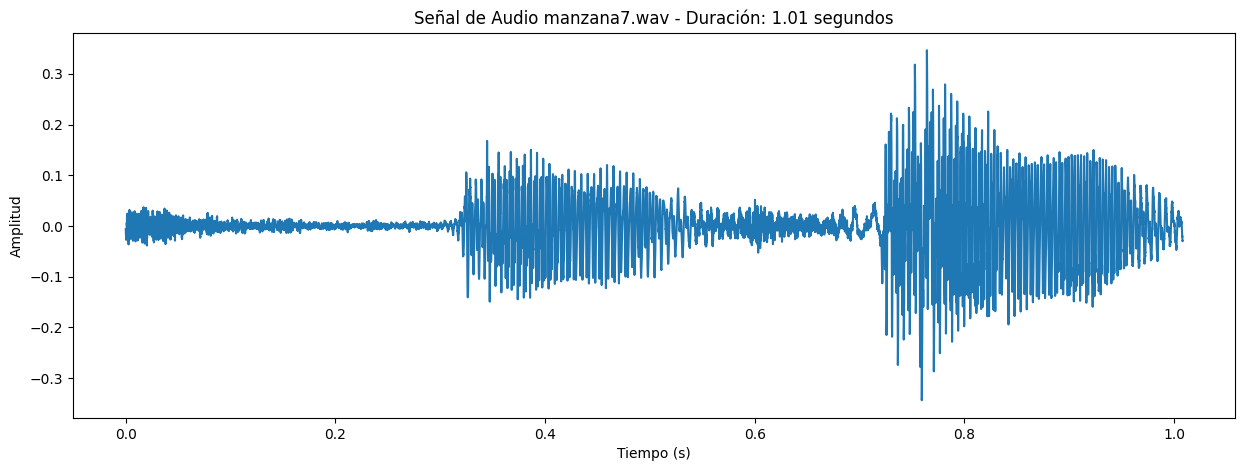

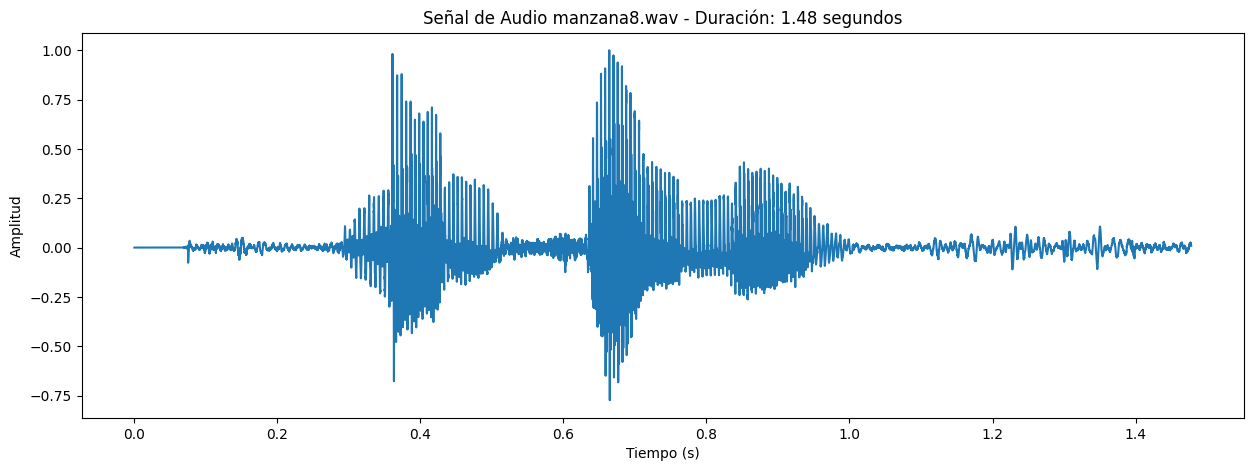

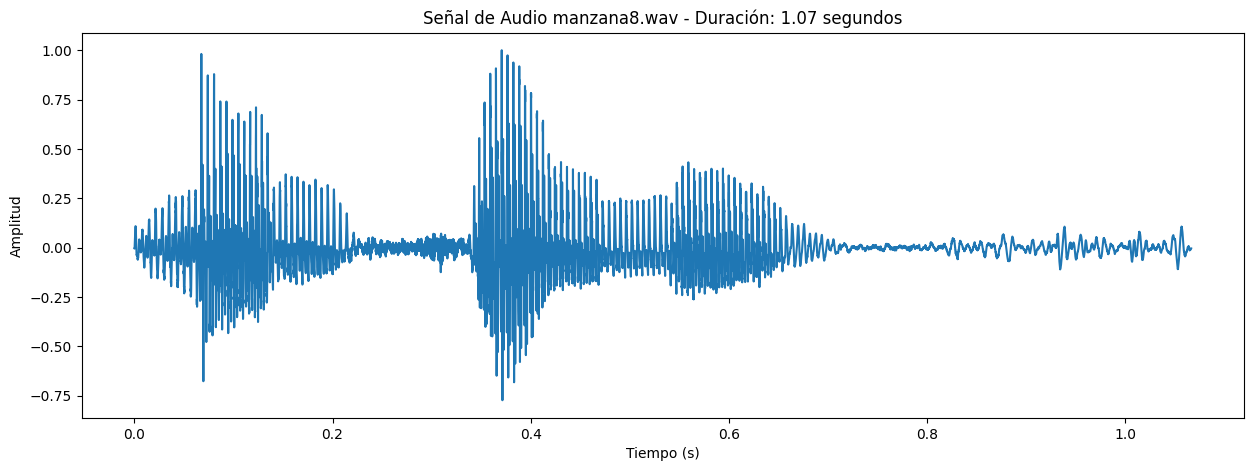

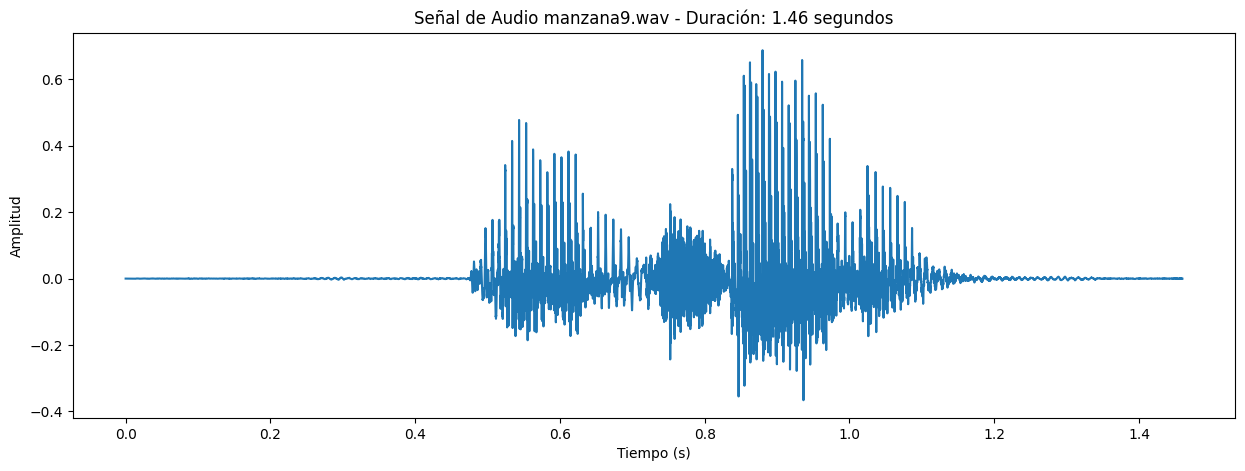

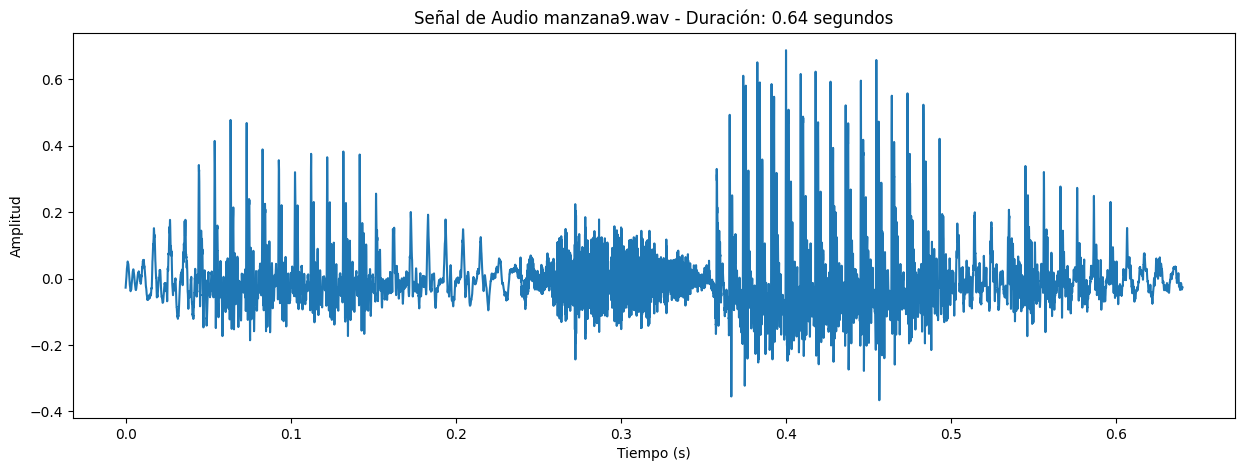

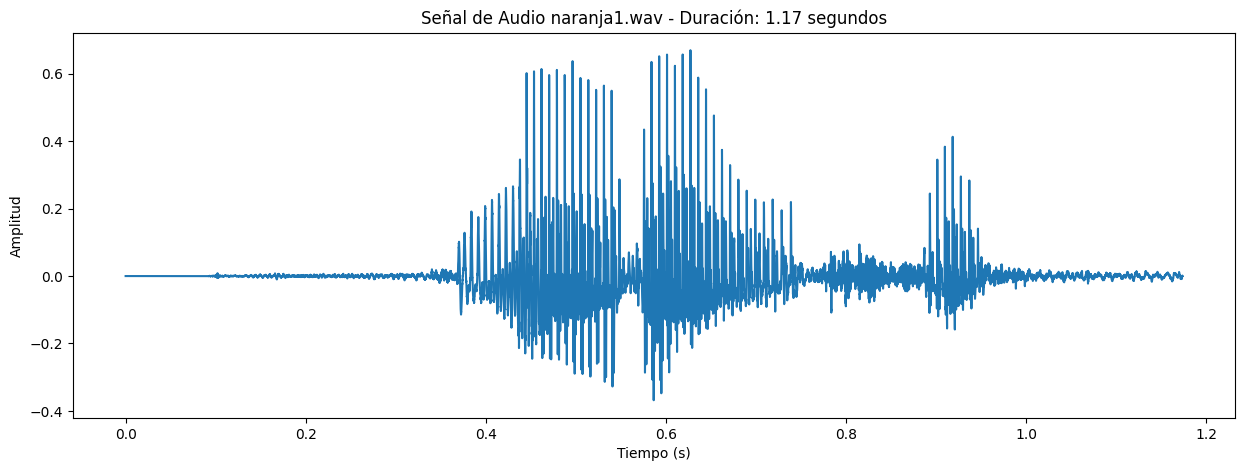

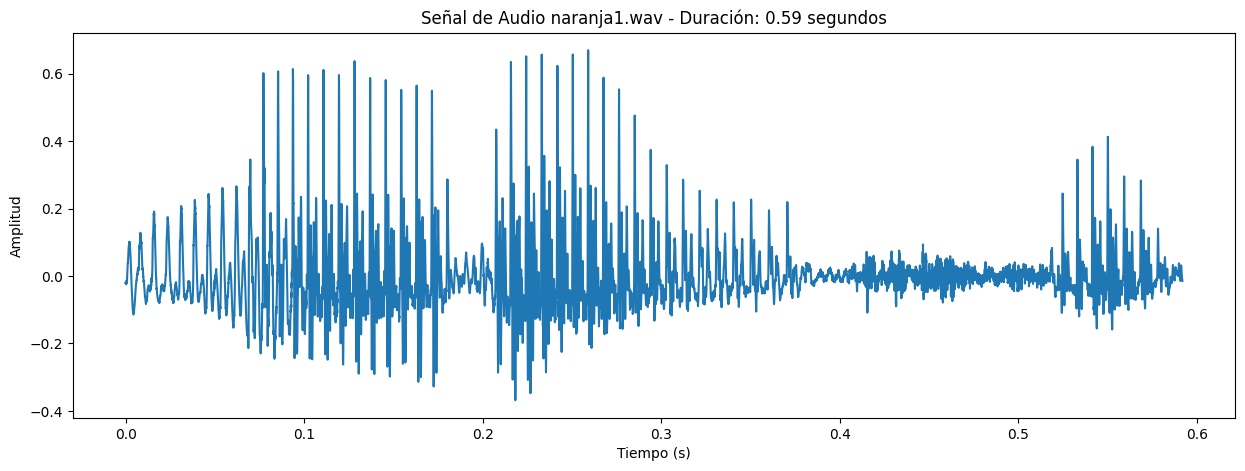

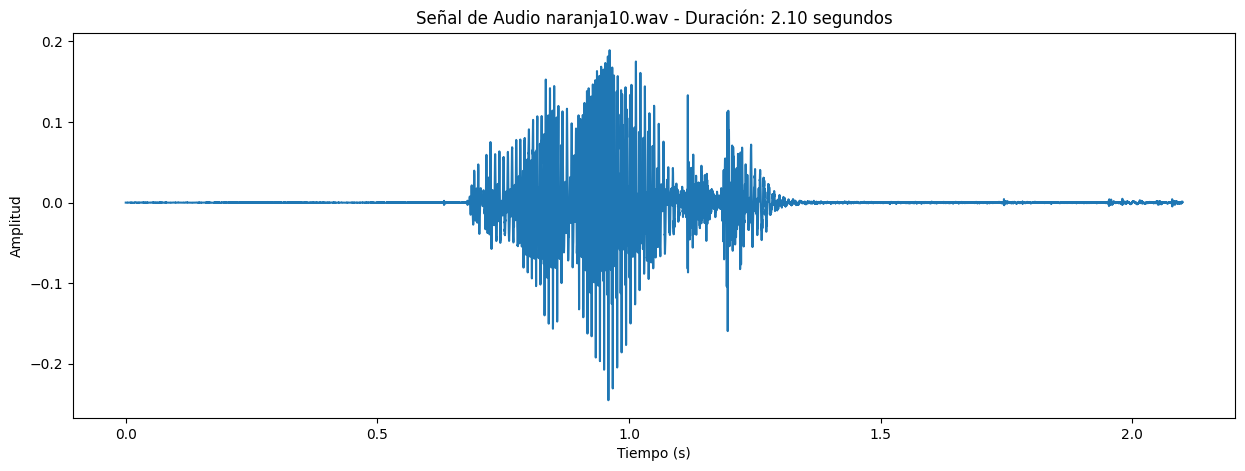

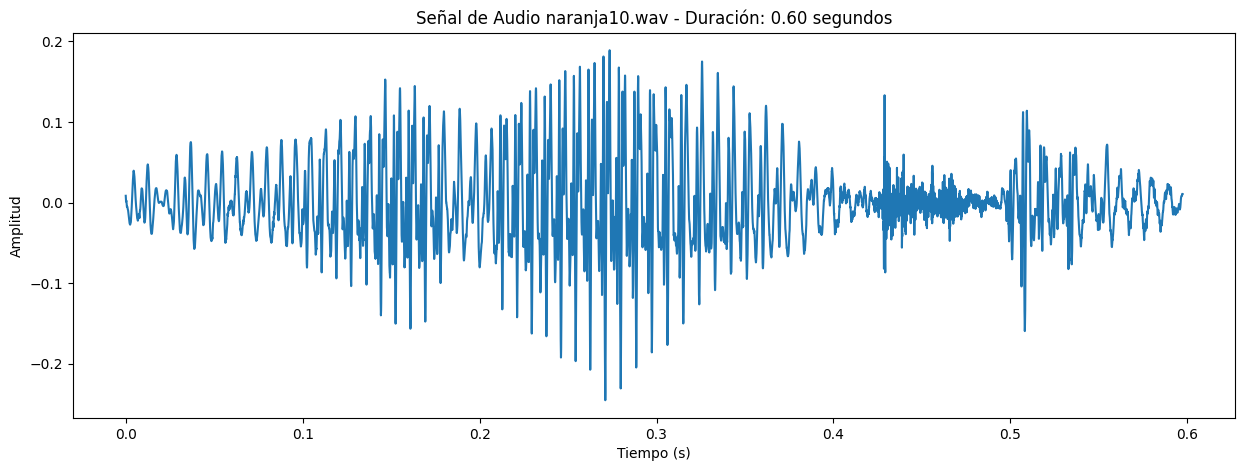

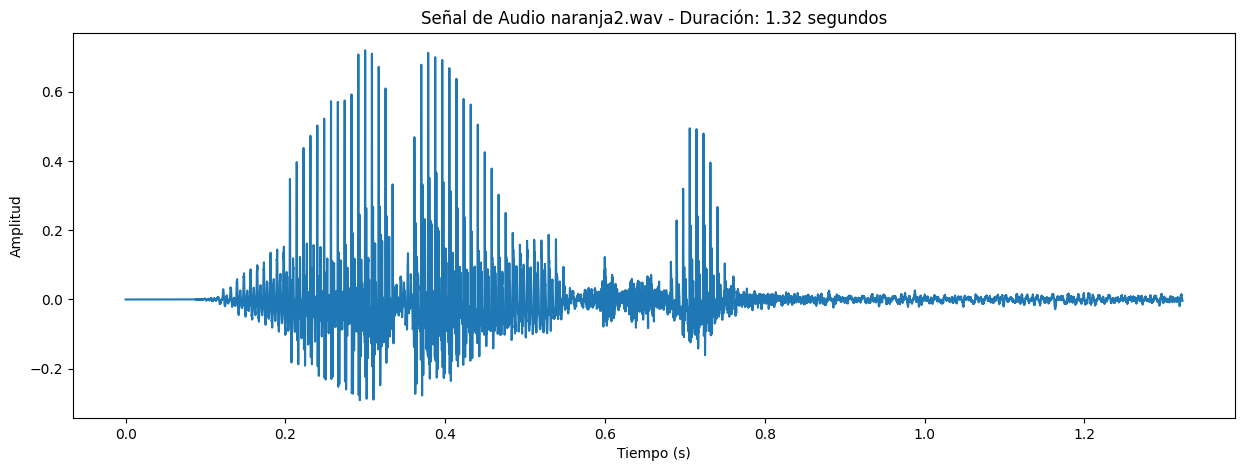

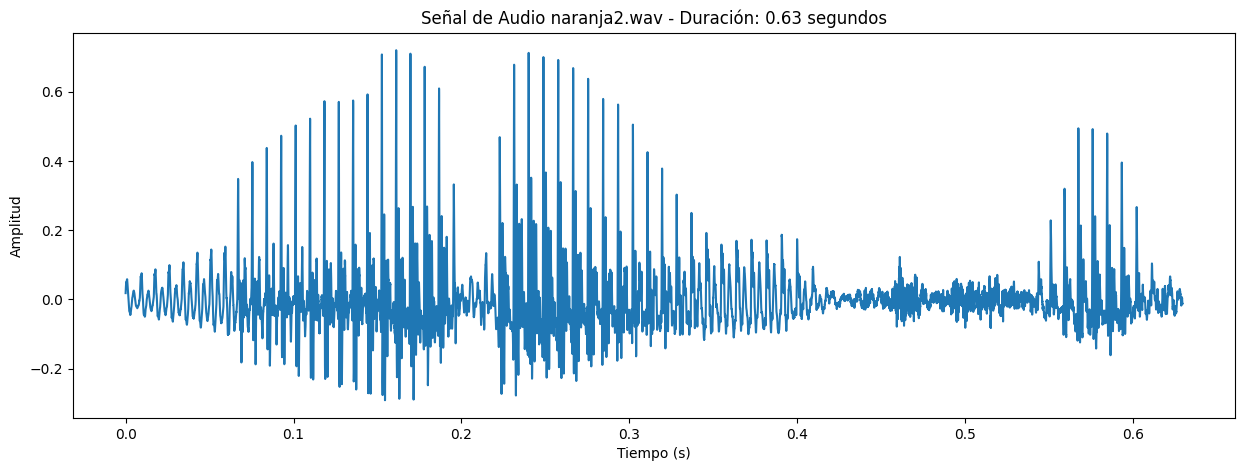

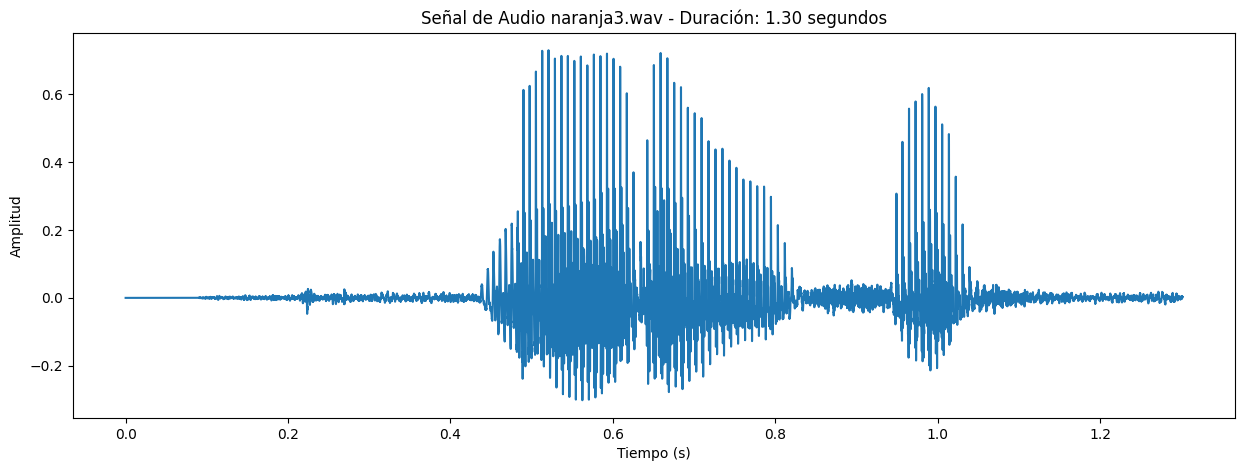

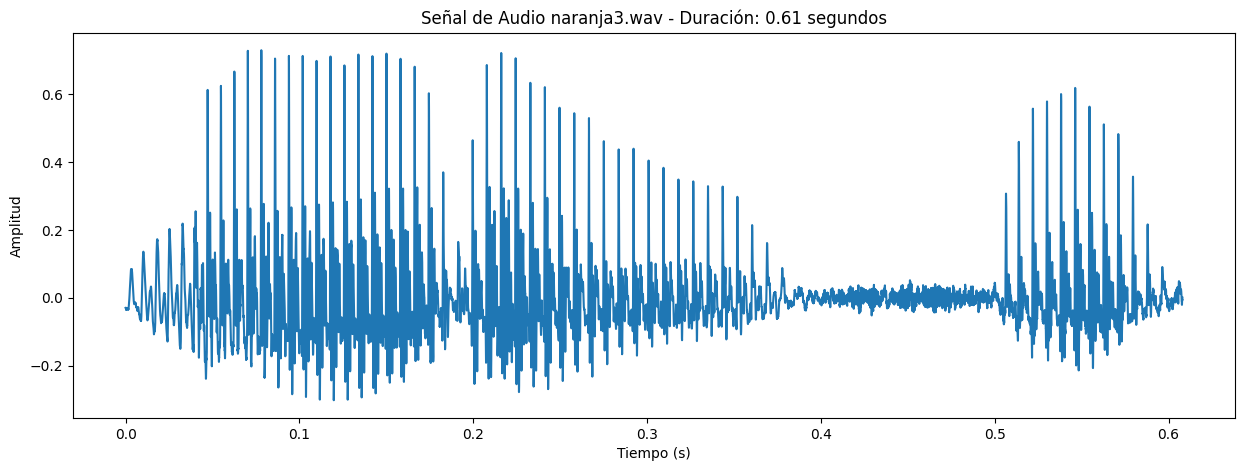

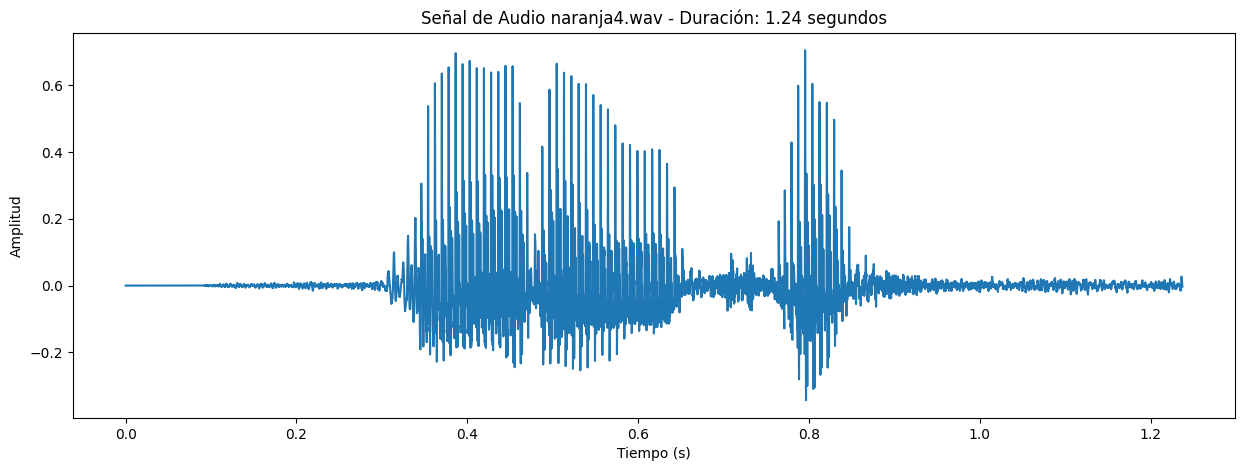

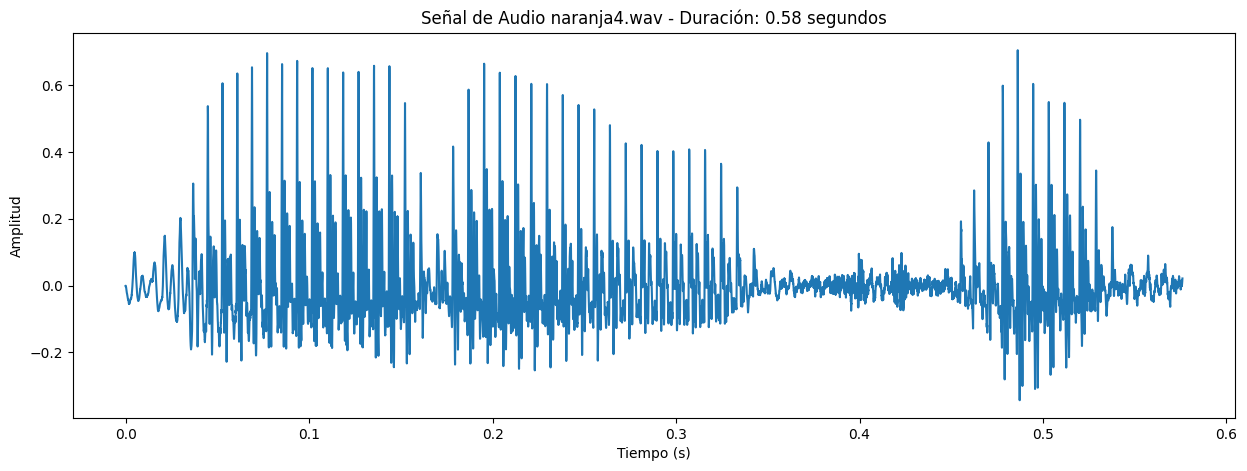

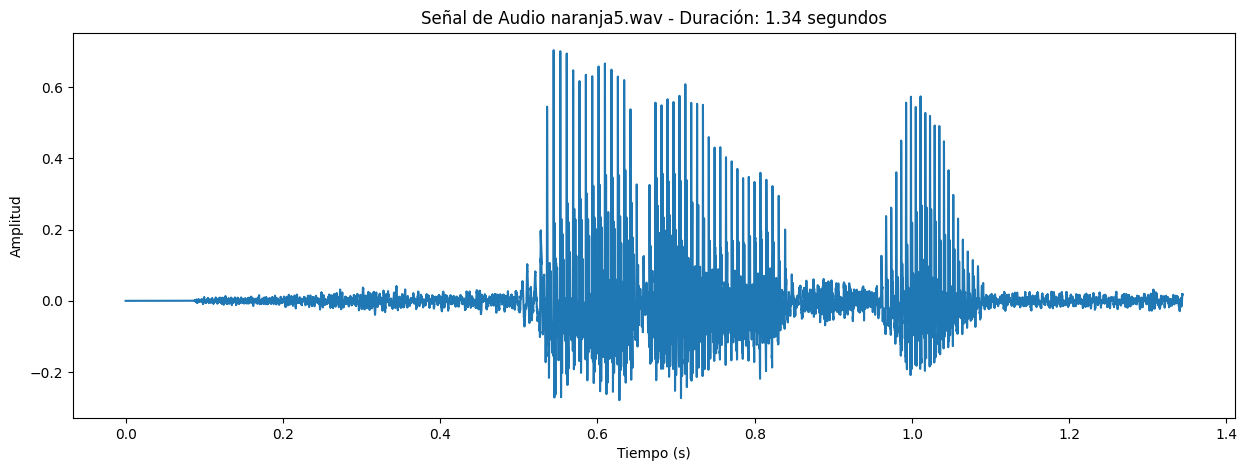

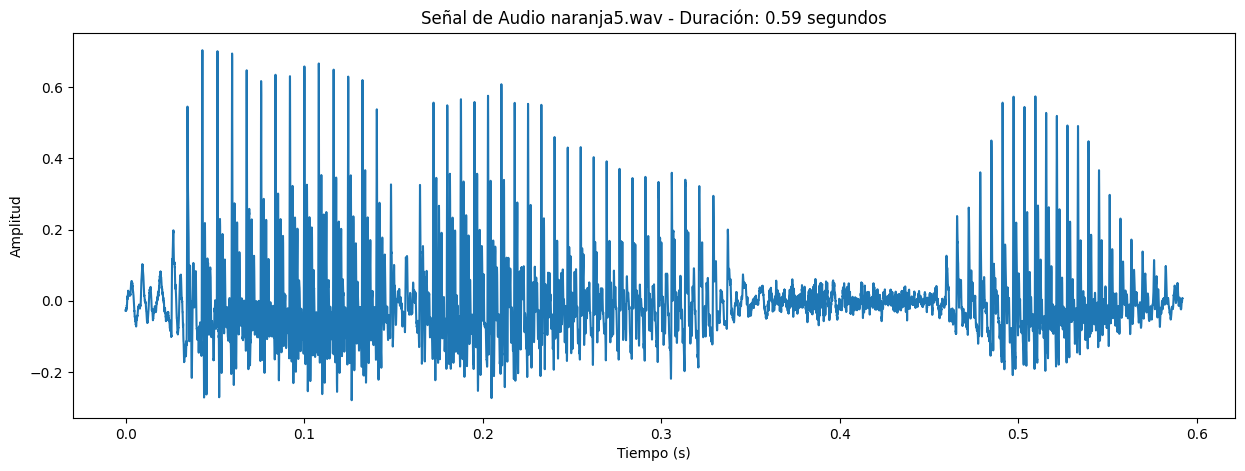

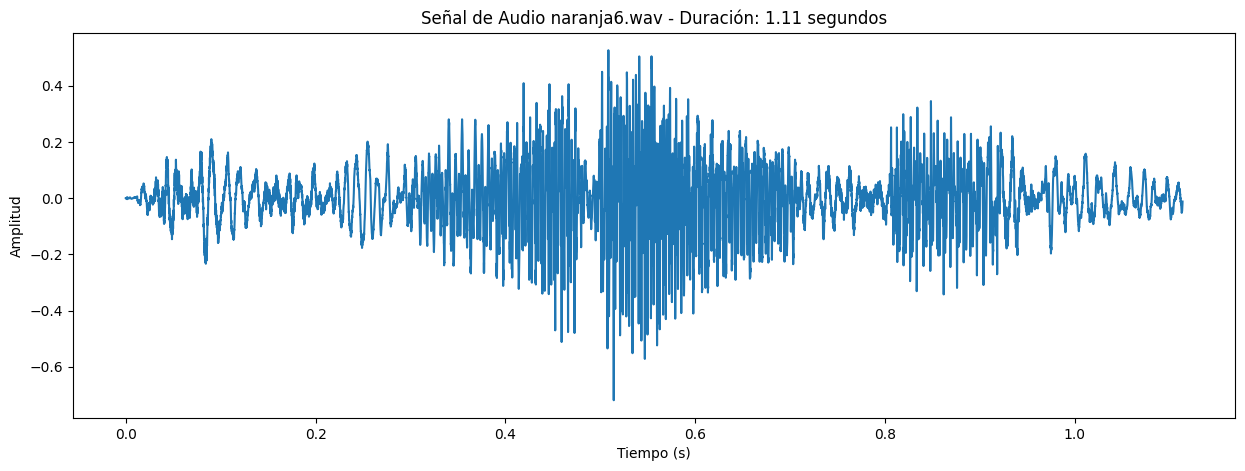

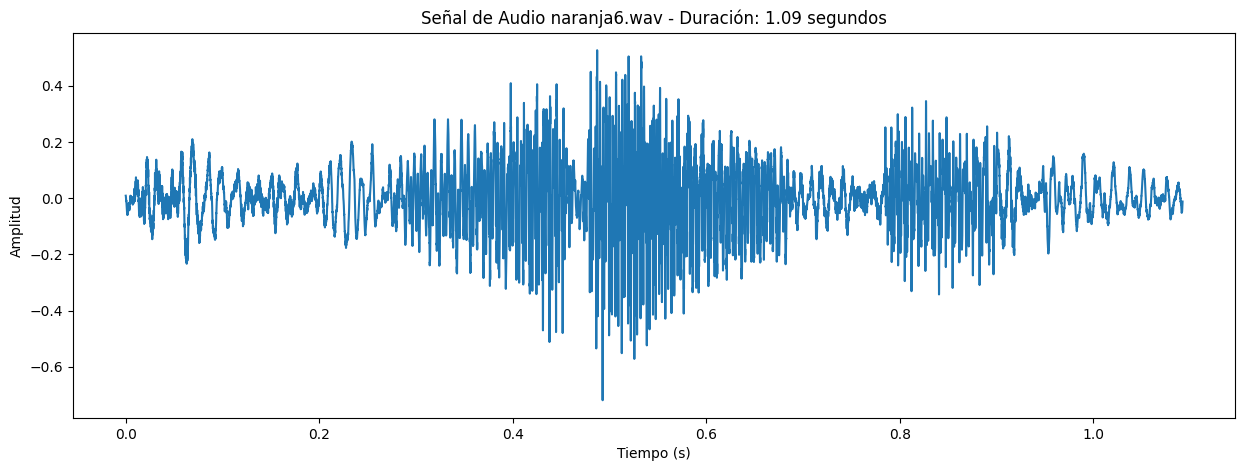

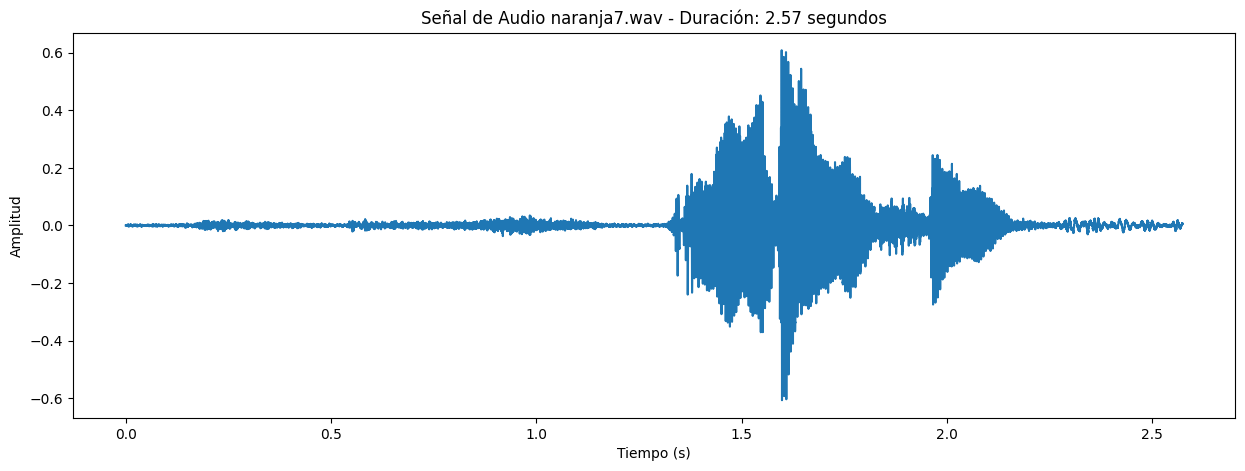

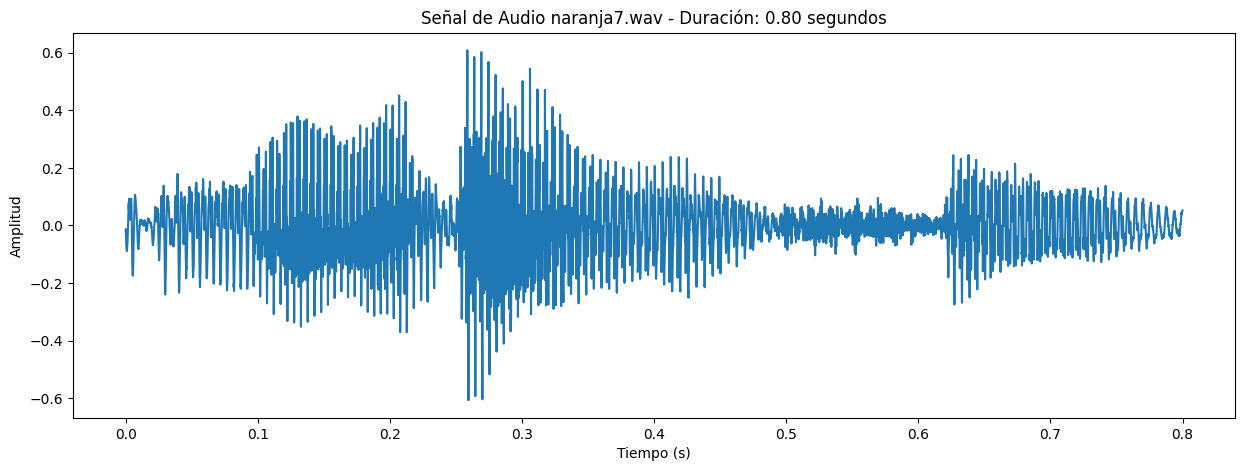

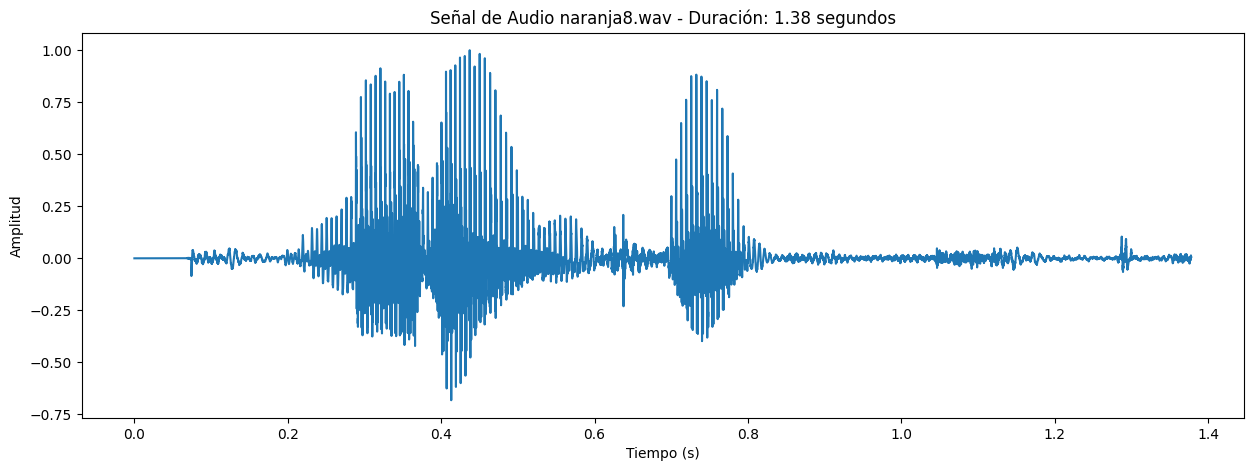

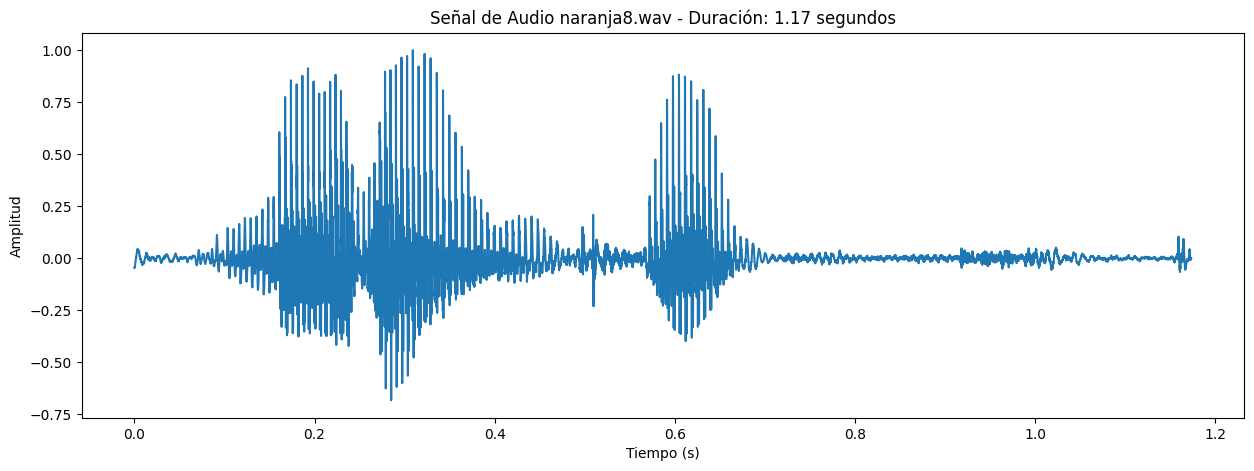

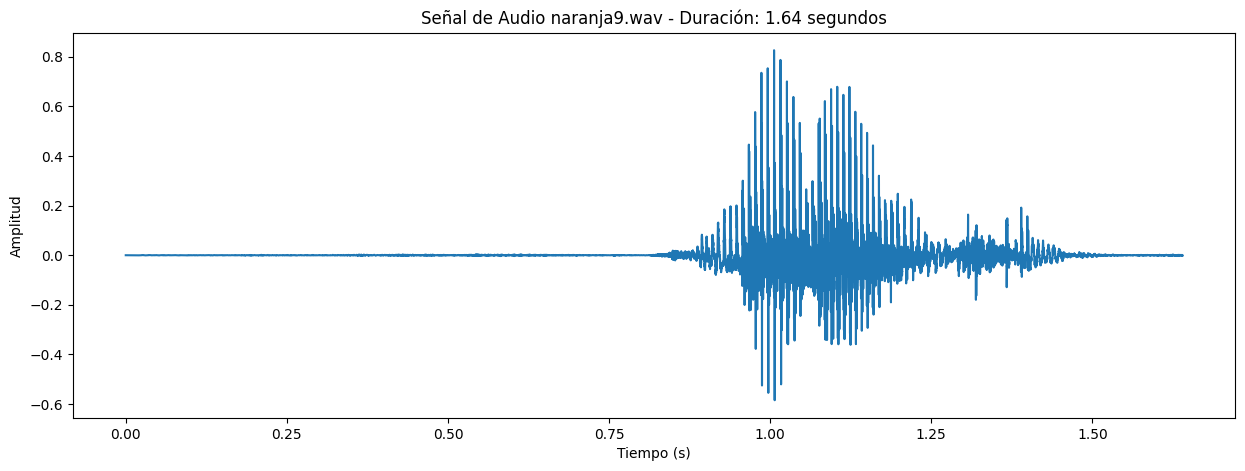

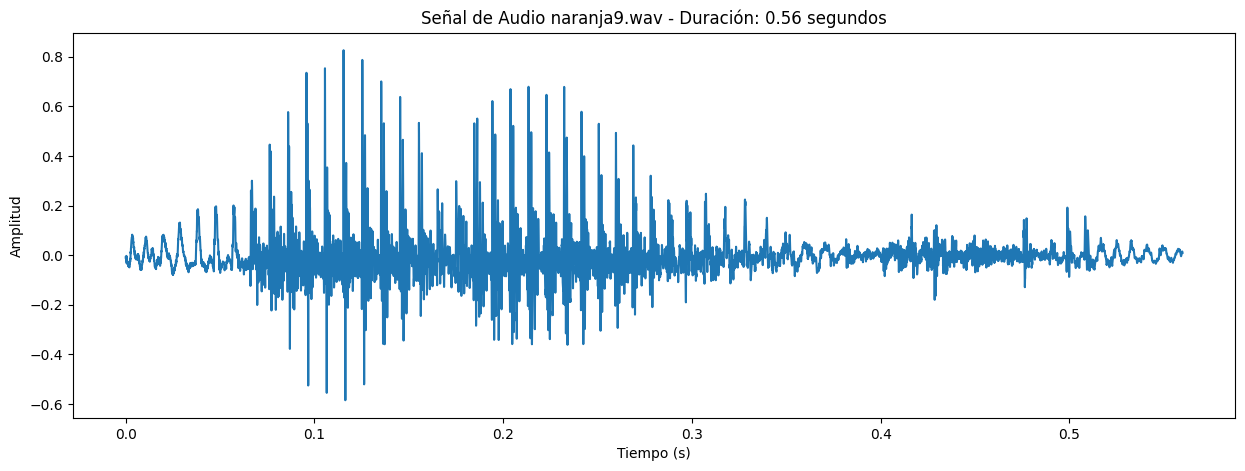

In [62]:
#comparacion gráficas
for type in audios:
    for i, _ in enumerate(audios[type]):
        plot_signal(audios[type][i])
        plot_signal(trimed_audio[type][i])
        input()

problemas de ruido en pera6, banana6, banana7(un pico al final), banana8(ruido al inicio), manzana6(ruido al inicio), manzana7 (ruido al inicio), manzana8(ruido al final), naranja8(picos al final)

In [78]:
#comparacion audios
type = 'naranja'
indice = 8
ipd.Audio(audios[type][indice])

In [79]:
ipd.Audio(trimed_audio[type][indice])